In [1]:
import os

N_THREADS = "4"
os.environ["OMP_NUM_THREADS"] = N_THREADS
os.environ["OPENBLAS_NUM_THREADS"] = N_THREADS
os.environ["MKL_NUM_THREADS"] = N_THREADS
os.environ["VECLIB_MAXIMUM_THREADS"] = N_THREADS
os.environ["NUMEXPR_NUM_THREADS"] = N_THREADS

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import preliz as pz
import pymc as pm

import gEconpy as ge
import gEconpy.plotting as gp

seed = sum(map(ord, "Two Households Example"))
rng = np.random.default_rng(seed)

gp.set_matplotlib_style()

# A Simple Two-Household Model

In this model, we take a look at a simple model with two households. These are sometimes called TANK models, for "Two Agent New Keynesian". I'm not including nominal frictions though, so it's not really NK and I'll refrain from calling it that.

This model is interesting because it's a case where we can't fully describe the steady state. We will see that in these cases, gEconpy is able to automatically work out how to deploy an optimizer. The user is able to partially describe the steady state, and this information will also be incorporated.

The down side of this is that Bayesian estimation of the model is not available. Currently, this requires that the model steady state be analytically described. I hope to change this in the near future, though! To circumvent this, we also study a strategically simplified two-household model that has an analytic steady state. We examine what is lost in terms of expressive power, and a parameter recovery exercise is peformed. 

## A bunch of algebra

In the model, we will have a fraction $\omega \in (0, 1)$ of individuals coming from the "Ricardian" household, and $1 - \omega$ coming from the "non-Ricardian" household. A household is described as "Ricardian" if it has access to financial markets. Ricardian households save by investing in installed capital, and recieve rents on that capital from firms. Non-Ricardian households, on the other hand, cannot invest. They live "hand to mouth", spending all of their income on consumption.

Total consumption and labor across the economy is additive, so $C_t = \omega C_{t,R} + (1 - \omega) C_{t, NR}$ and $L_t = \omega L_{t,R} + (1 - \omega) L_{t, NR}$. The firm is indifferent to who it hires. Everyone goes into a big labor pool and recieves identical wage $w_t$. This is where the steady-state blues come in. If we assume a CRRA utility for each household:

$$ u_{x,t} = \frac{C_{x,t}^{1 - \sigma_C}}{1 - \sigma_C} - \frac{L_{x,t}^{1 + \sigma_L}}{1+\sigma_L} $$

Dropping the $t$ subscript to denote the steady state, labor supply for each household will be the usual solution:

$$ C_{x}^{\sigma_C} L_{x}^{\sigma_L} = w $$

Or, solving for $C_{x,t}$ as a function of $L_{x,t}$ :

$$ C_{x} = w^{\frac{1}{\sigma_C}} L_{x}^{-\frac{\sigma_L}{\sigma_C}}$$

Focusing on the non-Ricardian households, they consume all their income, and their income only comes from labor. So their budget constraint is very simple:

$$ C_{NR} = w L_{NR} $$

Plugging in the above expression and solving for $L_{NR}$:

$$
\begin{align}
w^{\frac{1}{\sigma_C}} L_{NR}^{-\frac{\sigma_L}{\sigma_C}} = w L_{NR} \\
L_{NR}^{-\left ( 1 + \frac{\sigma_L}{\sigma_C} \right ) } &= w^{1 - \frac{1}{\sigma_C}} \\
L_{NR}^{-\frac{\sigma_C + \sigma_L}{\sigma_C}} &= w^{\frac{\sigma_C - 1}{\sigma_L}} \\
L_{NR} &= w^{\frac{1 - \sigma_C}{\sigma_C + \sigma_L}}
\end{align}
$$

So that total consumption in the economy is:

$$ C = \omega w^{\frac{1}{\sigma_C}} L_{R}^{-\frac{\sigma_L}{\sigma_C}} + (1 - \omega) w^{\frac{1}{\sigma_C}} L_{NR}^{-\frac{\sigma_L}{\sigma_C}} $$

From the law of motion of capital, we know that $I = \delta K$. Defining $N = \frac{K}{L}$ as the capital-labor ratio, that's $I = \delta N L$. We can also re-write the Cobb-Douglas production function as $Y = N^\alpha L$. From the firm problem we know $N = \left ( \frac{\alpha \mu}{r} \right )^{\frac{1}{1 - \alpha}}$ So the total resource contraint in the economy will be:

$$
\begin{align}
Y &= C + I \\
N^\alpha L &= \omega w^{\frac{1}{\sigma_C}} L_{R}^{-\frac{\sigma_L}{\sigma_C}} + (1 - \omega) w^{\frac{1}{\sigma_C}} L_{NR}^{-\frac{\sigma_L}{\sigma_C}} + \delta N L \\
(N^\alpha - \delta N)L &= \omega w^{\frac{1}{\sigma_C}} L_{R}^{-\frac{\sigma_L}{\sigma_C}} + (1 - \omega) w^{\frac{1}{\sigma_C}} L_{NR}^{-\frac{\sigma_L}{\sigma_C}}
\end{align}
$$

In the "usual" setup, we could divide through and solve for $L$, but here we're stuck, because $L_{NR}$ cannot be trivially isolated. We know $L = \omega L_R + (1 - \omega) L_{NR}$, so plug that in and do some algebra:

$$
\begin{align}
(N^\alpha - \delta N) \left ( \omega L_R + (1 - \omega) L_{NR} \right ) &= \omega w^{\frac{1}{\sigma_C}} L_{R}^{-\frac{\sigma_L}{\sigma_C}} + (1 - \omega) w^{\frac{1}{\sigma_C}} L_{NR}^{-\frac{\sigma_L}{\sigma_C}} \\
(N^\alpha - \delta N)\omega L_R - \omega w^{\frac{1}{\sigma_C}} L_{R}^{-\frac{\sigma_L}{\sigma_C}} &= (1 - \omega) w^{\frac{1}{\sigma_C}} L_{NR}^{-\frac{\sigma_L}{\sigma_C}} - (N^\alpha - \delta N) (1 - \omega) L_{NR}
\end{align}
$$

Now we're good and stuck. You can see that the right-hand side is competely known. The left-hand side, however, cannot be further simplifed to isolate and solve for $L_R$. As a result, we need to resort to numerical methods to solve this steady state.

# Load and Solve

In this model, note that we still provide a `steady_state` block. This contains a *partial* steady state, which has solutions for:

1. Trivial expressions ($TFP$, $\zeta_\beta$, $r$, $mc$)
2. The firm's problem, which does not change
3. Aggregate variables, which also don't change. 

We can actually ignore the household-specific consumption and labor and obtain the usual expressions for aggregate output, investment, consumption, and capital. Since the household variables are omitted, they will be computed numerically.

In [3]:
gcn_file = "../GCN Files/RBC_two_household.gcn"
ge.print_gcn_file(gcn_file)

In [4]:
mod = ge.model_from_gcn(gcn_file)

Model Building Complete.
Found:
	16 equations
	16 variables
		The following variables were eliminated at user request:
			TC_t, U_NR_t, U_R_t
		The following "variables" were defined as constants and have been substituted away:
			mc_t
	2 stochastic shocks
		 0 / 2 has a defined prior. 
	8 parameters
		 0 / 8 parameters has a defined prior. 
	0 parameters to calibrate.
Model appears well defined and ready to proceed to solving.



## How does a mixed steady-state work?

When you load a GCN file, several functions related to the steady state are compiled. They all start with `f_ss`, and here they are:

In [5]:
list(filter(lambda x: x.startswith("f_ss"), dir(mod)))

['f_ss',
 'f_ss_error',
 'f_ss_error_grad',
 'f_ss_error_hess',
 'f_ss_error_hessp',
 'f_ss_jac',
 'f_ss_resid']

### `f_ss`

`f_ss(param_values)` computes analytical values provided in the GCN file given `param_values`

In [6]:
mod.f_ss(**mod.parameters())

{'C_ss': 2.3584361407514516,
 'I_ss': 0.714646368841605,
 'K_ss': 35.73231844208025,
 'L_ss': 0.8200691321870385,
 'TFP_ss': 1.0,
 'Y_ss': 3.073082509593058,
 'r_ss': 0.030101010101010184,
 'shock_beta_R_ss': 1.0,
 'w_ss': 2.4357746839078733}

### `f_ss_resid`

`f_ss_resid(ss_values, param_values)` computes the "residuls" of model equations, cast to the steady state. Taking a Cobb-Douglas production function as an example. The equation is "normalized" to put zero on the right-hand side, so $Y_{ss} - A_{ss} K_{ss}^\alpha L_{ss}^(1 - \alpha) = 0$. The residual is the value of the left-hand side, evaluated at a requested point.

Note that when the full analytical steady state is provided, `f_ss_resid(f_ss(param_values), param_values)` should return the zero vector.
  
To demonstrate, we guess that the unknown steady state are all 0.8, and compute the residuals  

In [7]:
from gEconpy.classes.containers import SymbolDictionary

ss_guess = SymbolDictionary({x.to_ss(): 0.8 for x in mod.variables}).to_string()
# ss_guess._assumptions = {x.to_ss(): x._assumptions for x in mod.variables}
ss_guess.update(mod.f_ss(**mod.parameters()))

In [8]:
mod.f_ss_resid(**ss_guess, **mod.parameters())

array([-0.00000000e+00,  0.00000000e+00,  5.97542486e-01,  1.30861975e+00,
        0.00000000e+00,  0.00000000e+00,  1.14861975e+00,  5.97542486e-01,
        1.30861975e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -1.33226763e-15, -2.00691322e-02, -1.55843614e+00])

Symbolically, we're plugging in the provided values into the model system of equations 

In [9]:
for eq in mod.equations:
    print("Normalied Steady-State Equation:")
    display(ge.utilities.eq_to_ss(eq))

    print("After substitution:")
    display(ge.utilities.eq_to_ss(eq).subs(ss_guess.to_sympy(), doit=False))
    print("-" * 100)

Normalied Steady-State Equation:


rho_beta_R*log(shock_beta_R_ss) + epsilon_beta_R_ss - log(shock_beta_R_ss)

After substitution:


epsilon_beta_R_ss

----------------------------------------------------------------------------------------------------
Normalied Steady-State Equation:


I_ss + K_ss*(1 - delta) - K_ss

After substitution:


0.714646368841606 - 35.7323184420802*delta

----------------------------------------------------------------------------------------------------
Normalied Steady-State Equation:


-lambda_R_ss + shock_beta_R_ss/C_R_ss**sigma_C

After substitution:


-0.8 + 1.0/0.8**sigma_C

----------------------------------------------------------------------------------------------------
Normalied Steady-State Equation:


-L_R_ss**sigma_L*shock_beta_R_ss + lambda_R_ss*w_ss

After substitution:


1.9486197471263 - 1.0*0.8**sigma_L

----------------------------------------------------------------------------------------------------
Normalied Steady-State Equation:


-lambda_R_ss + q_ss

After substitution:


0

----------------------------------------------------------------------------------------------------
Normalied Steady-State Equation:


beta*(lambda_R_ss*r_ss - q_ss*(delta - 1)) - q_ss

After substitution:


beta*(0.824080808080808 - 0.8*delta) - 0.8

----------------------------------------------------------------------------------------------------
Normalied Steady-State Equation:


-C_NR_ss + L_NR_ss*w_ss

After substitution:


1.14861974712630

----------------------------------------------------------------------------------------------------
Normalied Steady-State Equation:


-lambda_NR_ss + C_NR_ss**(-sigma_C)

After substitution:


-0.8 + 0.8**(-sigma_C)

----------------------------------------------------------------------------------------------------
Normalied Steady-State Equation:


-L_NR_ss**sigma_L + lambda_NR_ss*w_ss

After substitution:


1.9486197471263 - 0.8**sigma_L

----------------------------------------------------------------------------------------------------
Normalied Steady-State Equation:


rho_TFP*log(TFP_ss) + epsilon_TFP_ss - log(TFP_ss)

After substitution:


epsilon_TFP_ss

----------------------------------------------------------------------------------------------------
Normalied Steady-State Equation:


K_ss**alpha*L_ss**(1 - alpha)*TFP_ss - Y_ss

After substitution:


1.0*0.820069132187038**(1 - alpha)*35.7323184420802**alpha - 3.07308250959306

----------------------------------------------------------------------------------------------------
Normalied Steady-State Equation:


alpha*K_ss**(alpha - 1)*L_ss**(1 - alpha)*TFP_ss - r_ss

After substitution:


1.0*0.820069132187038**(1 - alpha)*35.7323184420802**(alpha - 1)*alpha - 0.0301010101010102

----------------------------------------------------------------------------------------------------
Normalied Steady-State Equation:


TFP_ss*(K_ss/L_ss)**alpha*(1 - alpha) - w_ss

After substitution:


1.0*43.5723246243715**alpha*(1 - alpha) - 2.43577468390787

----------------------------------------------------------------------------------------------------
Normalied Steady-State Equation:


C_ss + I_ss - Y_ss

After substitution:


-1.33226762955019e-15

----------------------------------------------------------------------------------------------------
Normalied Steady-State Equation:


omega*L_R_ss + L_NR_ss*(1 - omega) - L_ss

After substitution:


-0.0200691321870384

----------------------------------------------------------------------------------------------------
Normalied Steady-State Equation:


omega*C_R_ss + C_NR_ss*(1 - omega) - C_ss

After substitution:


-1.55843614075145

----------------------------------------------------------------------------------------------------


### `f_ss_jac`

`f_ss_jac` returns the jacobian matrix of the steady state equations with respect to steady state variables. This is used for **root finding** when the steady state problem is square. 

In [10]:
with np.printoptions(linewidth=1000, precision=2, suppress=True):
    print(mod.f_ss_jac(**ss_guess, **mod.parameters()))

[[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   -0.05  0.  ]
 [ 0.    0.    0.    1.   -0.02  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.   -2.62  0.    0.    0.    0.    0.    0.    0.    0.   -1.    0.    0.    1.4   0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.   -1.6   0.    0.    0.    2.44  0.    0.   -0.64  0.8 ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   -1.    1.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.03 -0.03  0.79  0.    0.  ]
 [ 0.   -1.    0.    0.    0.    0.    2.44  0.    0.    0.    0.    0.    0.    0.    0.    0.8 ]
 [ 0.   -2.62  0.    0.    0.    0.    0.    0.    0.    0.   -1.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.   -1.6   0.    0.    0.    2.44  0.    0.    0.    0.    0.8 ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.   -0.05  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0

### `f_ss_error`

`f_ss_error` returns the sum of squared errors for the residuals, so `f_ss_error(ss_values, param_values) == (f_ss_resid(ss_values, param_values) ** 2).sum()`. This is used as the objective function for **minimization** when the steady state problem is _not_ square.

In [11]:
mod.f_ss_error(**ss_guess, **mod.parameters())

7.887538628493717

In [12]:
(mod.f_ss_resid(**ss_guess, **mod.parameters()) ** 2).sum()

7.887538628493717

### Derivaties of the error function

`f_ss_error_grad`, `f_ss_error_hess`, and `f_ss_error_hessp` are support functions computing (respectively), the gradient of the error function with respect to steady state variables, the hessian matrix of the error of the same, and the hessian-vector product of the same. 


## Putting it together

So, when you load a file with an incomplete steady state, gEconpy will first subsitute in your provided answers and do **extremely rudimentary** simplification. If the simplification eliminates an equation (that is, a normalized symbolic expression becomes $0 = 0$), that variable and equation are eliminated from the steady state system entirely, and the system remains *square*. Since the system is square, a **root finding algorithm** is used by default.

A more common case is that the computer algebra system can't see the elimination that your equation implies. In this case, the variable is *still eliminated*, but all equations remain. Since the system is no longer square, the system switches to **error minimization** to find a steady state, but:

1. The provided equations are used as-in inside the minimization! If the system has $n$ equations and you provide $k$ steady-state relationships, then only $n-k$ values are chosen by the optimizer
2. The gradient vector and hessian matrix (or jvp) are _masked_, so that the optimizer never sees them.

The precise procedure is:

1. Taking the requested parameters, compute steady-state values for requested variables using the provided equations. Call this k-length vector $x_a$
2. The optimizer proposes a vector of values for the remaining values, $x_b$.
3. Form $x = [x_a | x_b]$ by concatenating these two vectors, re-arranging if necessary.
4. Evaluate the loss, gradient, and hessian using $x$.
5. Mask values of the gradient and hessian that correspond to $x_a$, the values the optimizer did *not* choose
6. Update the optimizer's choice of $x_b$ and repeat until convergence

## Just do it already!

All of this is done for you automatically, so you never have to worry about. Just call `mod.steady_state`.

Setting `verbose=True` (the default) gives a report about the solution that we find. Errors are small, and the norm of the gradient is close to zero, so we can be satisfied that we've found a steady state.

In [13]:
steady_state = mod.steady_state(verbose=True)

Output()

Steady state found
--------------------------------------------------------------------------------
Optimizer message             `xtol` termination condition is satisfied.
Sum of squared residuals      8.878708643961777e-06
Maximum absoluate error       0.001996319759718035
Gradient L2-norm at solution  0.004128304888776321
Max abs gradient at solution  0.00399263951943607


Checking the residuals, we see that they are all zero

In [14]:
mod.f_ss_resid(**steady_state, **mod.parameters())

array([-0.00000000e+00,  0.00000000e+00,  1.58972313e-03,  6.52656070e-04,
       -3.61294328e-13,  1.07969189e-14, -4.83259673e-05,  1.21928377e-03,
        5.00573302e-04, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -1.33226763e-15,  1.99631976e-03,  4.47967105e-04])

We can also check the gradient of the loss function at the optimium. This should be zero, since we are optimizing a convex objective.

In [15]:
mod.f_ss_error_grad(**steady_state, **mod.parameters())

array([-8.95934211e-04,  1.90780725e-12, -2.71245737e-12, -1.77635684e-15,
        0.00000000e+00, -3.99263952e-03,  8.72829109e-12,  4.14765184e-12,
        0.00000000e+00,  3.55271368e-15,  2.50510723e-12,  1.05671027e-12,
       -7.23232152e-13,  5.13478149e-15,  5.90635908e-06,  5.46807030e-04])

To actually look at the steady state, use `ge.print_steady_state`, or just look at the dictionary.

In [16]:
ge.print_steady_state(steady_state)

C_ss                     2.358
C_NR_ss                  2.142
C_R_ss                   2.576
I_ss                     0.715
K_ss                    35.732
L_ss                     0.820
L_NR_ss                  0.879
L_R_ss                   0.765
TFP_ss                   1.000
Y_ss                     3.073
lambda_NR_ss             0.318
lambda_R_ss              0.240
q_ss                     0.240
r_ss                     0.030
shock_beta_R_ss          1.000
w_ss                     2.436


## A gotcha!

One gotcha is to make sure you are consistent when working with parameter updates. You will need to pass any updateed parameters used in `mod.steady_state` to `mod.parameters` when checking for convergence, or else the wrong values will be used and you'll get errors.

In [17]:
# Solve steady state when omega=0.9
ss2 = mod.steady_state(omega=0.9)

Output()

Steady state found
--------------------------------------------------------------------------------
Optimizer message             `xtol` termination condition is satisfied.
Sum of squared residuals      8.759444609555984e-08
Maximum absoluate error       0.0002226964118656194
Gradient L2-norm at solution  0.0003455700855835444
Max abs gradient at solution  0.0003305736887382338


In [18]:
# Check residuals. If you forget to update omega in the parameter vector, the results will be wrong!
mod.f_ss_resid(**ss2, **mod.parameters())

array([-0.00000000e+00,  0.00000000e+00,  2.22696412e-04,  9.14273387e-05,
       -1.29560251e-11,  3.86080057e-13, -4.86993220e-07,  2.12200286e-05,
        8.71182210e-06, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -1.33226763e-15,  2.69743725e-02, -9.49108646e-02])

In [19]:
# When the correct parameters are used, the residuals are zero as expected.
mod.f_ss_resid(**ss2, **mod.parameters(omega=0.9))

array([-0.00000000e+00,  0.00000000e+00,  2.22696412e-04,  9.14273387e-05,
       -1.29560251e-11,  3.86080057e-13, -4.86993220e-07,  2.12200286e-05,
        8.71182210e-06, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -1.33226763e-15,  1.65286844e-04,  4.23749033e-05])

# Effect of $\omega$ on the steady state

How does the steady state of the economy change as we vary $\omega$, the proportion of households that are Ricardian? To study this, we use a loop to numerically compute the steady state over a grid of $\omega$ values between 0 and 1, avoiding 0 and 1 themselves for numerical reasons.

In [20]:
omegas = np.linspace(0.05, 0.95, 20)
results = []
for omega in omegas:
    ss = mod.steady_state(verbose=False, omega=omega)
    ss["success"] = ss.success
    ss["omega"] = omega
    results.append(ss)

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Each call to `mod.steady_state` returns a `SteadyStateResult`, which works like a dictionary. We can pass a list of dictionary to `pd.DataFrame` to quickly make a table of data.

In [21]:
steady_states = pd.DataFrame(results)

# Check that all optimizations succeeded
steady_states.success.all()

True

Perhaps surprisingly, the aggregate variables in the steady state are not influenced by the composition of households in the economy! This is less surprising when you remember the procedure used to compute the steady state. The user equations are taken as given, and an optimizer solves for the remaining variables. All the aggregate variables were provided, so they must be fixed by definition!

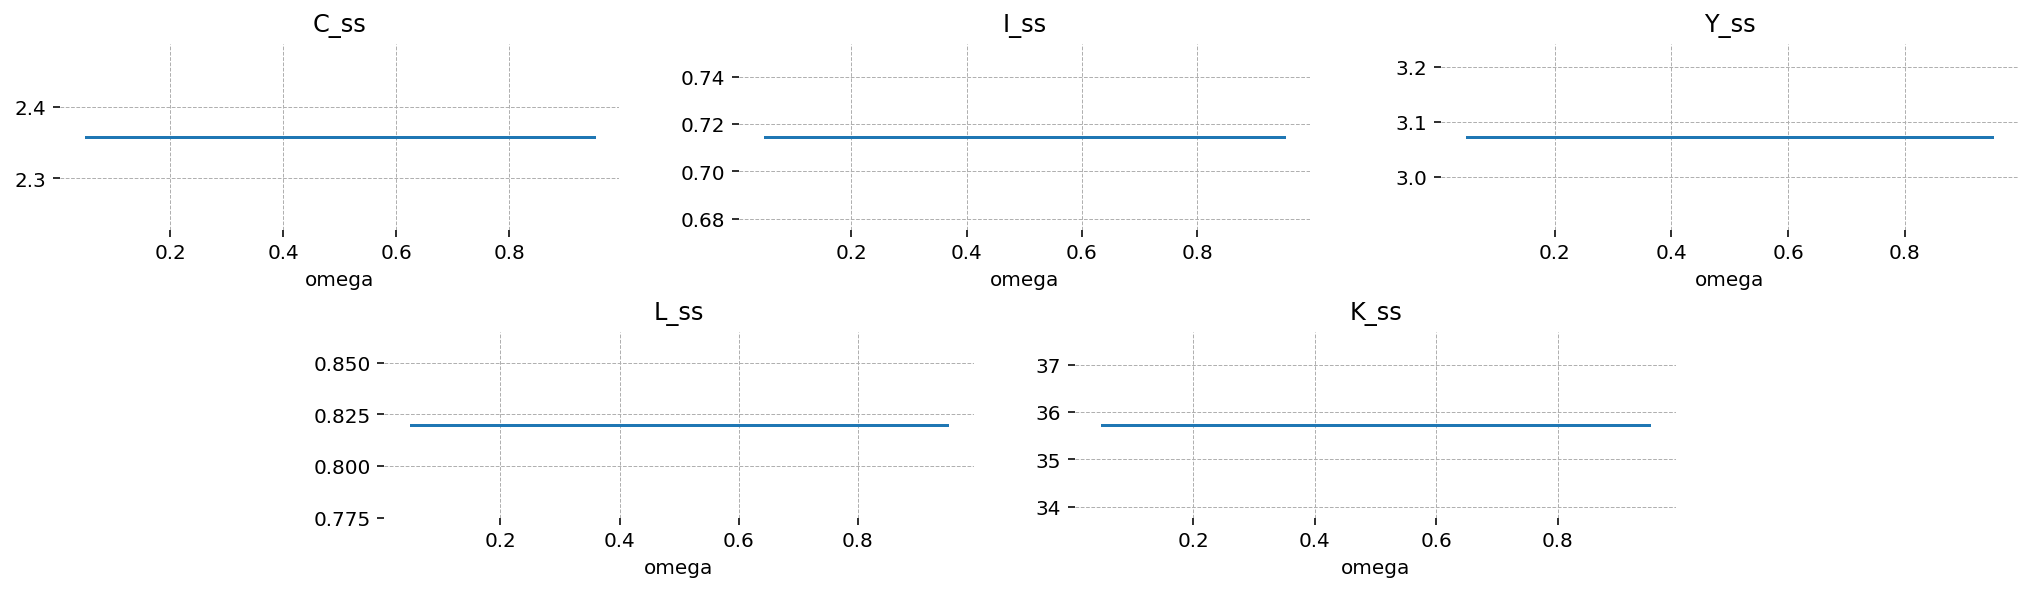

In [22]:
agg_vars = ["C_ss", "I_ss", "Y_ss", "L_ss", "K_ss"]
fig = plt.figure(figsize=(14, 4))
gs, locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=len(agg_vars), figure=fig)
for var, loc in zip(agg_vars, locs):
    axis = fig.add_subplot(gs[loc])
    steady_states.set_index("omega")[var].plot(ax=axis, title=var)
plt.show()

For the household variables, we see that as the share of Ricardian households ($\omega$) increases, those households each consume less and work more. This is explained by the pool of capital resources being held by a larger and larger population, who have to share the (fixed!) proceeds. As their size grows, they each have less income from capital rents, so they are forced to btoh cut back on consumption and increase working hours to suppliment their reduced income.

On the non-Ricardian side, effects are minor (notice the y-axis scale). But as the number of non-Ricardian households shrinks, the remaining households have to work more in response to the labor choice of the Ricardian households. Evidently, the increase in working hours by the Ricardians in the face of a change in $\omega$ is slightly less than what is required to maintain the fixed aggregate total working hours, so the non-Ricardians have to pick up the slack. Since they work more, they mechanically also consume more, having nothing else to do with their income.

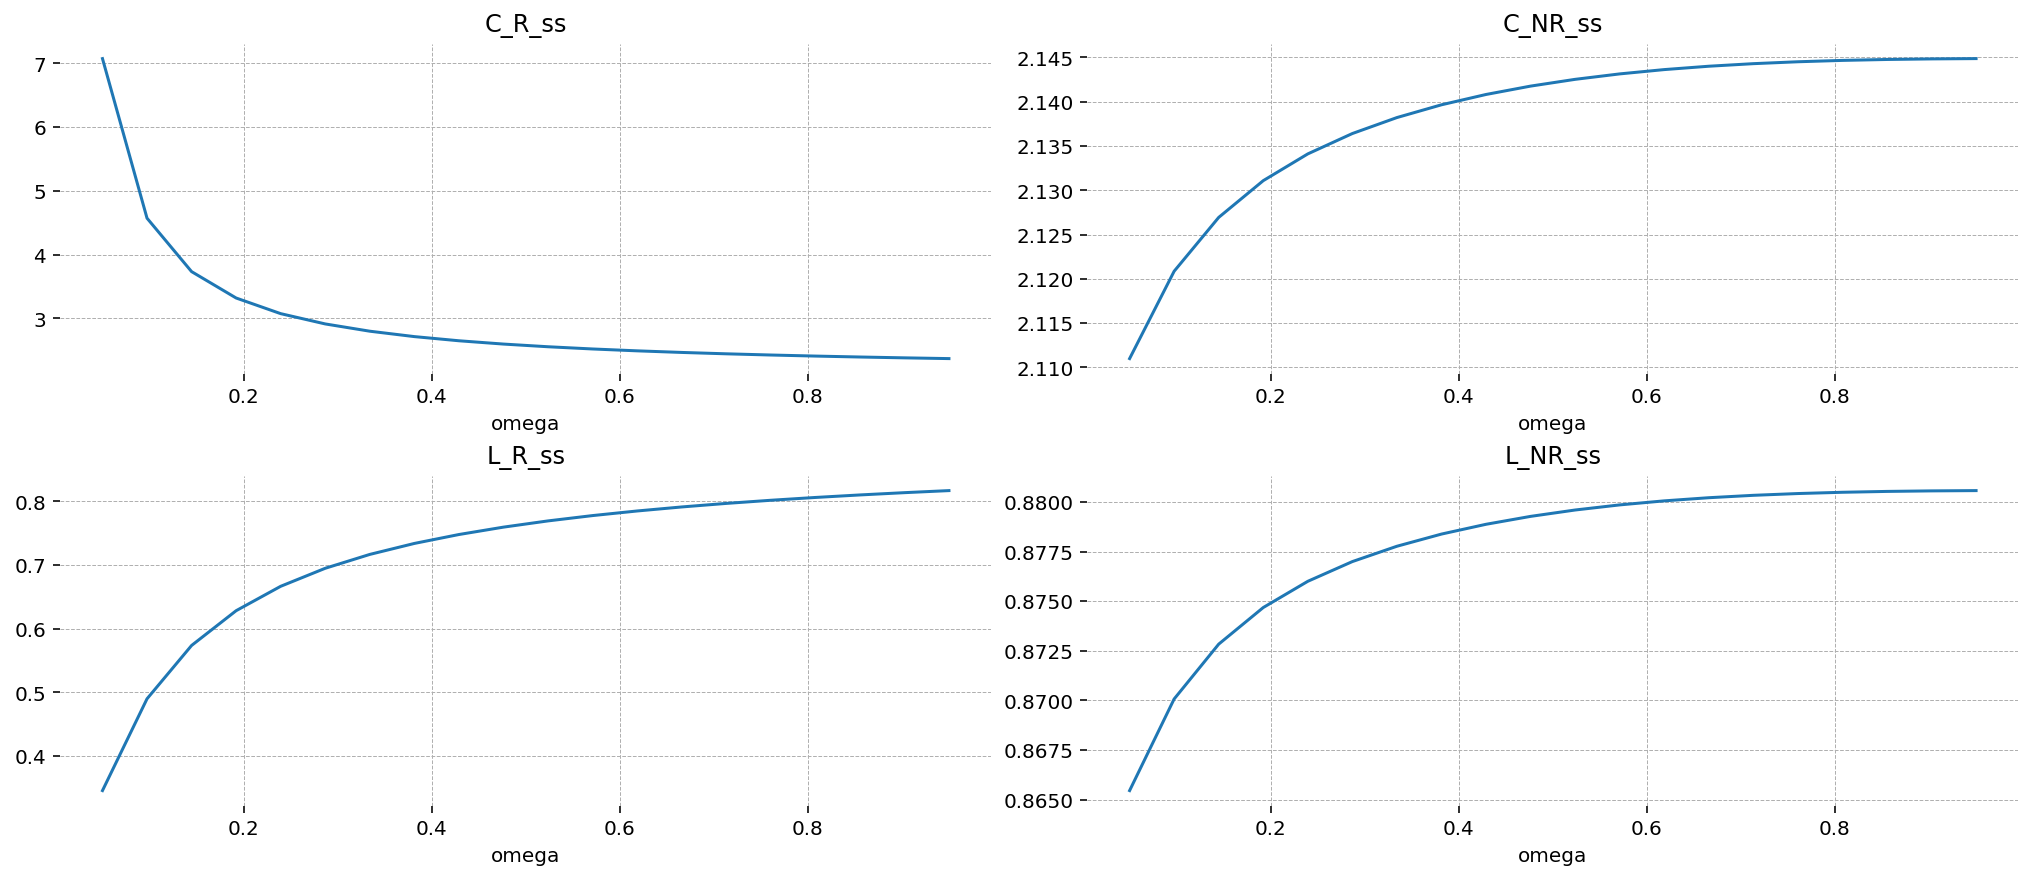

In [23]:
hh_vars = ["C_R_ss", "C_NR_ss", "L_R_ss", "L_NR_ss"]
fig = plt.figure(figsize=(14, 6))
gs, locs = gp.prepare_gridspec_figure(n_cols=2, n_plots=len(hh_vars), figure=fig)
for var, loc in zip(hh_vars, locs):
    axis = fig.add_subplot(gs[loc])
    steady_states.set_index("omega")[var].plot(ax=axis, title=var)
plt.show()

## Effect of $\omega$ on Model Dynamics 

To study the effect of changing $\omega$ on model dynamics, we plot impulse response functions for 3 model solutions: mostly non-Ricardian ($\omega = 0.2$), equal ($\omega = 0.5$), and mostly Ricardian ($\omega = 0.8$). 

There are two shocks in this model. One is to the discount factor $\beta$, and one is to total factor productivity (TFP).

### Discount Factor Shock

The discount factor only affects the model through the Ricardian households, because the non-Ricardian problem is static (they don't invest, and thus don't consider the future at all). The shock acts to increase the amount of time discounting Ricardian households do, causing them to view present consumption as more valuable compared to future consumption. The expected effect is to increase present consumption and decrease investment.   

As $\omega$ increases, the efffect of a discount factor shock to aggregate variables ($K, I, Y, C$) becomes larger. The opposite is true in the household variables. As expected, investment decreases, and as a result, capital stock decreases (with some lag). 

When there are more Ricardian households, consumption amonst Ricardian households increases less, and labor decreases less. This is due to the same "share-the-wealth" dynamics noted in the steady state analysis. As before, non-Ricardian households are just "along for the ride", and adjust as required given the choice of the Ricardian households.

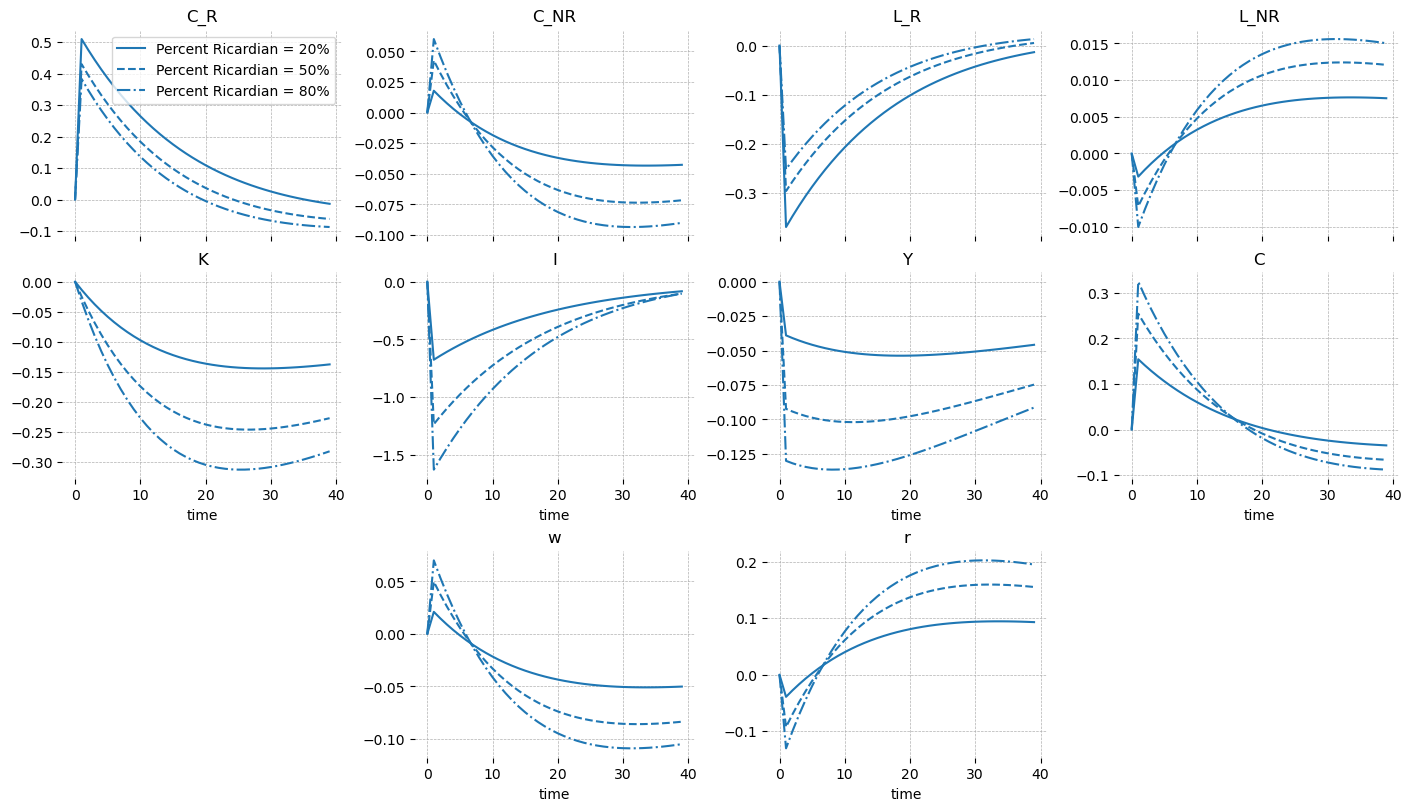

In [24]:
gp.plot_irf(
    {
        f"Percent Ricardian = {omega:0.0%}": ge.impulse_response_function(
            mod,
            shock_size={"epsilon_beta_R": 1.0},
            verbose=False,
            omega=omega,
            steady_state_kwargs={
                "how": "minimize",
                "verbose": False,
                "progressbar": False,
            },
        )
        for omega in [0.2, 0.5, 0.8]
    },
    ["C_R", "C_NR", "L_R", "L_NR", "K", "I", "Y", "C", "w", "r"],
    figsize=(14, 8),
);

### Total Factor Productivity Shock

When TFP is shocked, we expect output to increase, which in turn increases the price of input factors. These are income for the households, who can now consume and invest more. 

The only interesting difference here from the basic model is the reaction of the non-Ricardian households to additional income from wages. Given concave utility of consumption, they have no reason to work more and more, forever. At some point, it will provide more utility to enjoy more leisure rather than additional consumption. We can see that given the parameterization used, the make exactly this choice. Because wages go up, these households can enjoy *both* more consumption and more leisure by cutting back working hours.

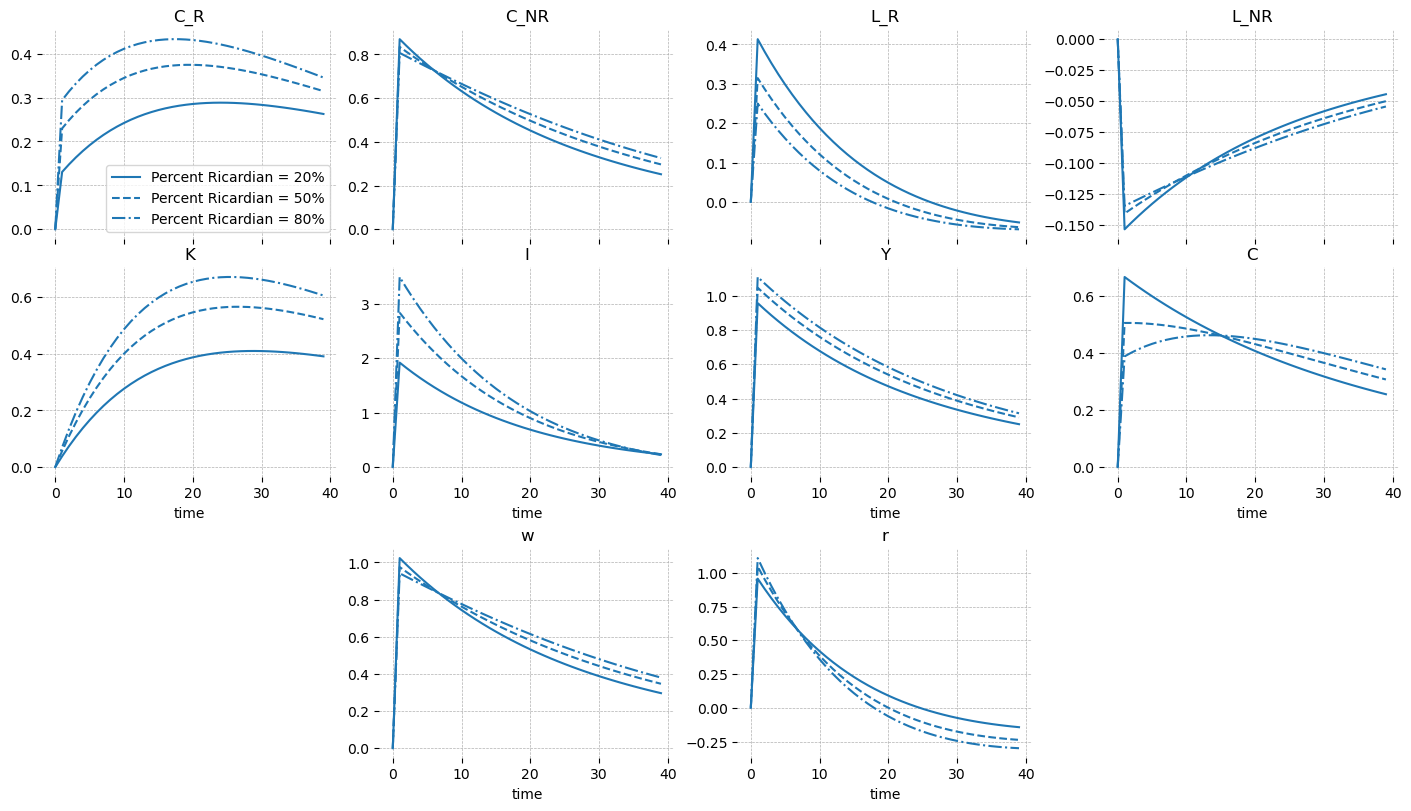

In [25]:
gp.plot_irf(
    {
        f"Percent Ricardian = {omega:0.0%}": ge.impulse_response_function(
            mod,
            shock_size={"epsilon_TFP": 1.0},
            verbose=False,
            omega=omega,
            steady_state_kwargs={
                "how": "minimize",
                "verbose": False,
                "progressbar": False,
            },
        )
        for omega in [0.2, 0.5, 0.8]
    },
    ["C_R", "C_NR", "L_R", "L_NR", "K", "I", "Y", "C", "w", "r"],
    figsize=(14, 8),
);

# An Analytic Version 

We saw previously that this model did not have a tractible steady state because we could not isolate and solve for $L_R$ after substituting everything into the total economic resource constraint. This was because of the awkward powers on $L_R$. A patch for this is switch utility to be linear in labor dispreference. The one-period utility function is now:

$$ u_{x,t} = \frac{C_t^{1 - \sigma_x}}{1 - \sigma_x} - \Theta_x L_{x,t} $$

This functional form isn't totally crazy. It corresponds to a setup where households choose labor particiption at the extensive, rather than the intensive, margin. That is, households will make the binary choice of whether to work or not work. To make this setup work, you have to assume that they get paid their full wage regardless of their choice due to a perfect unemployment insurance scheme operating behind the scenes. There's also no search frictions, and workers can show up to work or not as they please. Must be nice.

In this scheme, the parameter $\Theta$ is a combination of deeper parameters, including total working hours, the probability of choosing to work, and the inverse Frisch elasticity. In gEconpy, parameters are allowed to be defined as combinations of other parameters, so you are allowed to define these deeper parameteres in a `calibration` block and define `Theta_x` as an equation. This is not done here, though -- I just set $\Theta_x = 0$ because I'm lazy.  

## More algebra

Choosing this utility function causes $L_{x,t}$ to drop out of the labor supply curve for each household, and just become:

$$ 
C_{x,t}^{\sigma_x} = \frac{w_t}{\Theta_x} 
$$

So that once wages are known, consumption for both households is known, and aggregate consumption is immediately known:

$$
C = \omega \left ( \frac{w}{\Theta_R} \right ) ^{\frac{1}{\sigma_R}} + (1 - \omega) \left ( \frac{w}{\Theta_N} \right )^{\frac{1}{\sigma_N}}
$$

Plugging this into the total resource constraint:

$$
\begin{align}
Y &= C + I \\
N^\alpha L &= \omega \left ( \frac{w}{\Theta_R} \right ) ^{\frac{1}{\sigma_R}} + (1 - \omega) \left ( \frac{w}{\Theta_N} \right )^{\frac{1}{\sigma_N}} + \delta N L \\
\end{align}
$$

Since the labor terms dropped out of the aggregate consumption, we can easily solve this for aggregate labor:

$$
L = \frac{\omega \left ( \frac{w}{\Theta_R} \right ) ^{\frac{1}{\sigma_R}} + (1 - \omega) \left ( \frac{w}{\Theta_N} \right )^{\frac{1}{\sigma_N}}}{N^\alpha - \delta N}
$$

As before, we know the labor choice of the non-Ricardians from their budget constraint:

$$
L_{NR} = \frac{C_{NR}}{w}
$$

So $L_R$ is pinned down from the aggregate labor condition:

$$
L_{R} = \frac{L - (1 - \omega) L_{NR}}{\omega}
$$

And we're done! For specifics, check out the steady state block below

In [26]:
gcn_file = "../GCN Files/RBC_two_household_additive.gcn"
ge.print_gcn_file(gcn_file)

In [27]:
mod = ge.model_from_gcn(gcn_file)

Model Building Complete.
Found:
	18 equations
	18 variables
		The following variables were eliminated at user request:
			TC_t, U_NR_t, U_R_t
		The following "variables" were defined as constants and have been substituted away:
			mc_t
	4 stochastic shocks
		 0 / 4 has a defined prior. 
	12 parameters
		 12 / 12 parameters has a defined prior. 
	0 parameters to calibrate.
Model appears well defined and ready to proceed to solving.



Since the steady-state is now analytic, no progress bar pops up.

In [28]:
steady_state = mod.steady_state()
ge.print_steady_state(steady_state)

C_ss                     1.810
C_NR_ss                  1.810
C_R_ss                   1.810
I_ss                     0.549
K_ss                    27.428
L_ss                     0.629
L_NR_ss                  0.743
L_R_ss                   0.571
TFP_ss                   1.000
Theta_N_ss               1.000
Theta_R_ss               1.000
Y_ss                     2.359
lambda_NR_ss             0.411
lambda_R_ss              0.411
q_ss                     0.411
r_ss                     0.030
shock_beta_R_ss          1.000
w_ss                     2.436


You can still check the steady state residuals and gradients, though

In [29]:
mod.f_ss_error(**steady_state, **mod.parameters())

6.0401977880844684e-31

In [30]:
mod.f_ss_error_grad(**steady_state, **mod.parameters())

array([ 8.88178420e-16, -8.88178420e-16,  0.00000000e+00,  8.88178420e-16,
        2.67251679e-17,  1.99840144e-15,  2.23889768e-15,  1.46549439e-16,
        2.09553527e-15,  0.00000000e+00, -0.00000000e+00, -1.77635684e-15,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.38777878e-17,
        0.00000000e+00,  6.60117398e-16])

## New effect of $\omega$ on the steady state

As before, we iterate over a sequence of $\omega$ values and plot the results.

In [31]:
results_analyic = []
for omega in omegas:
    ss = mod.steady_state(verbose=False, omega=omega)
    ss["success"] = ss.success
    ss["omega"] = omega
    results_analyic.append(ss)

results_analytic_df = pd.DataFrame(results_analyic)

As before, aggregate variables are not affected by changes in the household composition of the economy. Compared to the CRRA case we studied above (in orange), the new model also has lower steady state values of all variables.

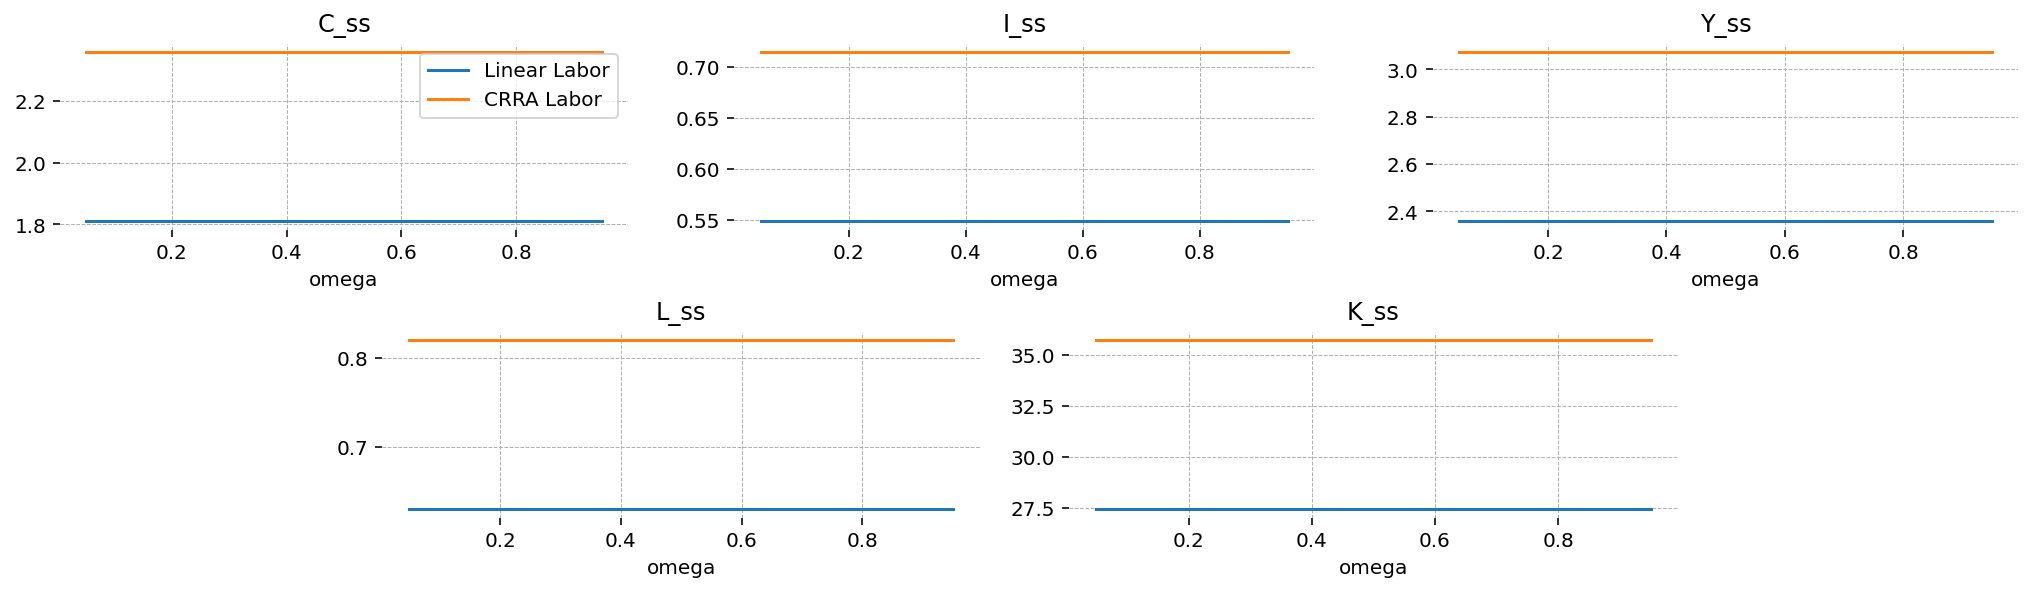

In [32]:
fig = plt.figure(figsize=(14, 4))
gs, locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=len(agg_vars), figure=fig)
for var, loc in zip(agg_vars, locs):
    axis = fig.add_subplot(gs[loc])
    results_analytic_df.set_index("omega")[var].plot(
        ax=axis, title=var, label="Linear Labor"
    )
    steady_states.set_index("omega")[var].plot(
        ax=axis, color="tab:orange", label="CRRA Labor"
    )

fig.axes[0].legend()
plt.show()

What changes now is that the *household* level variables are also much less responsive! In fact, only $L_R$ is a function of $\omega$. This is actually clear in the algebra above, when we saw that household consumptions in the steady state are completely pinned down by the labor supply curve. So consumption is a function of wages only, which in turn is a function only of aggregate variables, which are not a function of the composition of the economy.

Compared to the the CRRA labor case (orange), $L_R$ is much more responsive to changes in $\omega$.

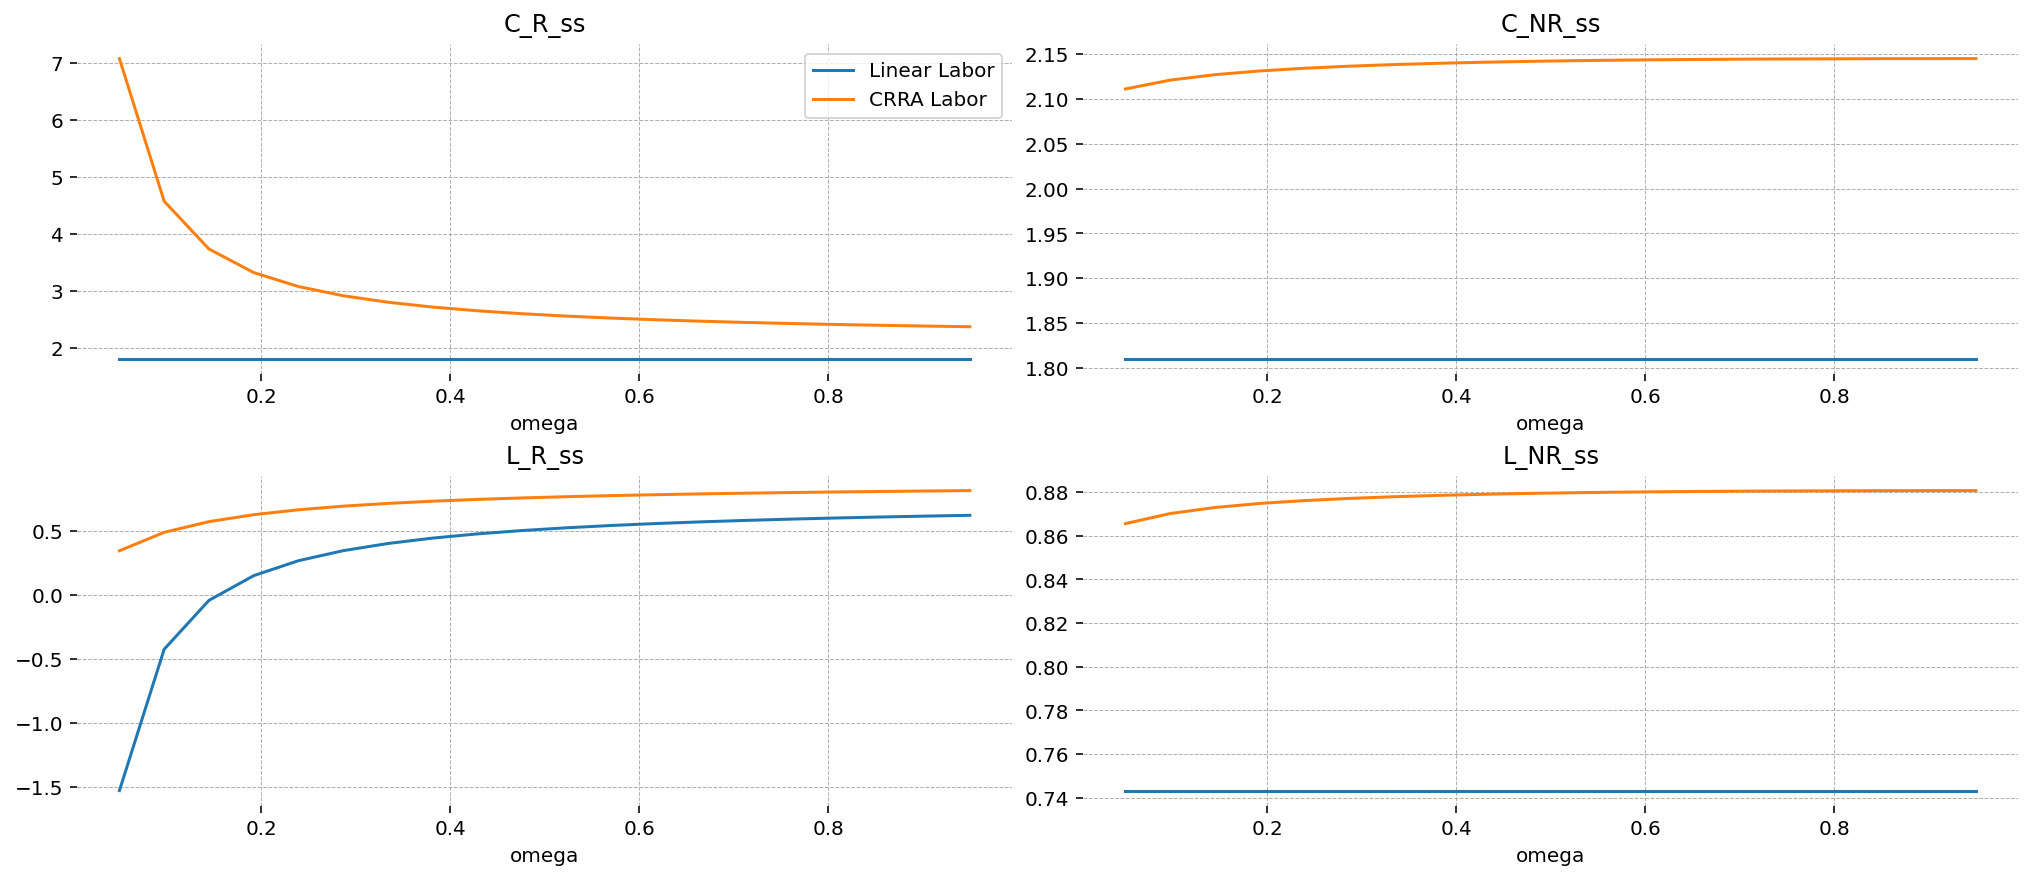

In [33]:
fig = plt.figure(figsize=(14, 6))
gs, locs = gp.prepare_gridspec_figure(n_cols=2, n_plots=len(hh_vars), figure=fig)
for var, loc in zip(hh_vars, locs):
    axis = fig.add_subplot(gs[loc])
    results_analytic_df.set_index("omega")[var].plot(
        ax=axis, title=var, label="Linear Labor"
    )
    steady_states.set_index("omega")[var].plot(
        ax=axis, color="tab:orange", label="CRRA Labor"
    )

fig.axes[0].legend()
plt.show()

## New effect of $\omega$ on dynamics

In the CRRA case, we saw that when $\omega$ was low, a small group of households were given access to a fixed pot of capital, which made them richer, causing them to consume more and work less. Non-linearities in the utility function with respect to labor made this shifts out of balance with the (fixed!) aggregate variables, so non-Ricardian households were forced to make adjustments in the face of the choices of the Ricardian households.

On the other hand, when labor dispreference is linear, no such tradeoff exists. The choices of the Ricardian households are always balanced with respect to the aggregate variables, so their number doesn't change anything in the broader economy.

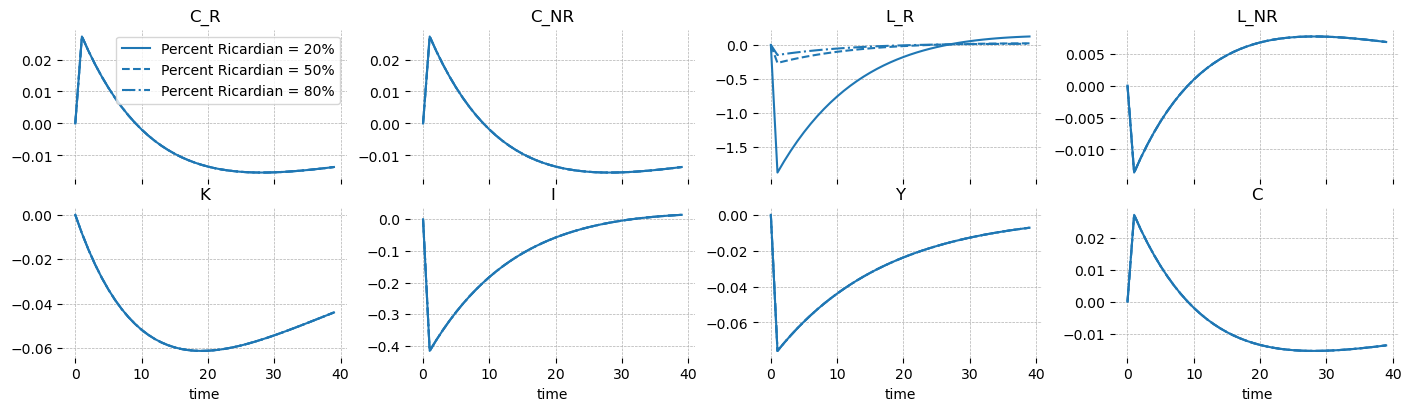

In [34]:
gp.plot_irf(
    {
        f"Percent Ricardian = {omega:0.0%}": ge.impulse_response_function(
            mod,
            shock_size={"epsilon_beta_R": 0.1},
            verbose=False,
            omega=omega,
            #             steady_state_kwargs={"how": "root", "verbose": False, "progressbar": False},
        )
        for omega in [0.2, 0.5, 0.8]
    },
    ["C_R", "C_NR", "L_R", "L_NR", "K", "I", "Y", "C"],
    figsize=(14, 4),
);

This same logic holds for a TFP shock. Since labor and consumption are disconnected, variation from TFP shocks will not identify variation in any of the model variables, save for $L_{R,t}$.

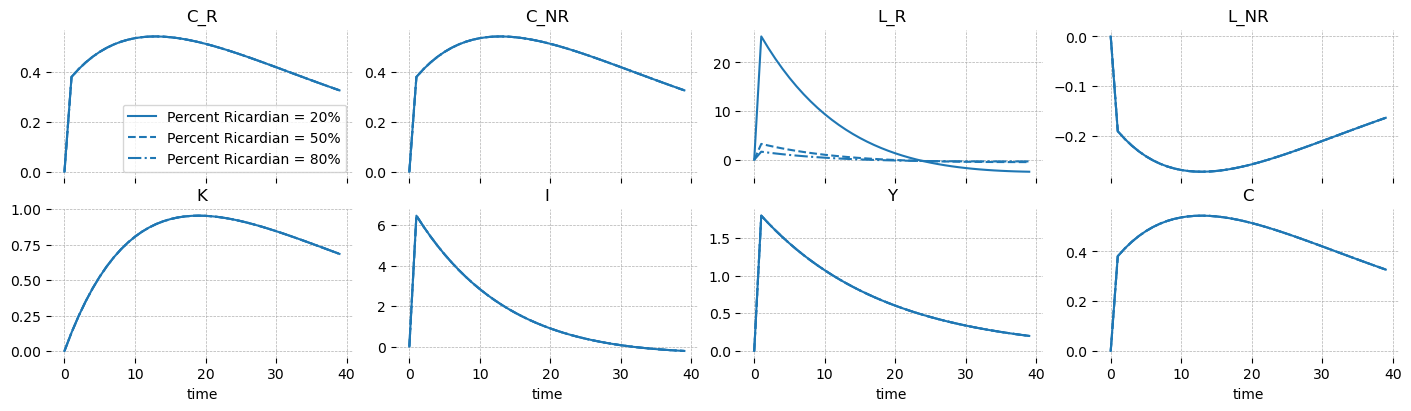

In [35]:
gp.plot_irf(
    {
        f"Percent Ricardian = {omega:0.0%}": ge.impulse_response_function(
            mod,
            shock_size={"epsilon_TFP": 1.0},
            verbose=False,
            omega=omega,
            #             steady_state_kwargs={"how": "root", "verbose": False, "progressbar": False},
        )
        for omega in [0.2, 0.5, 0.8]
    },
    ["C_R", "C_NR", "L_R", "L_NR", "K", "I", "Y", "C"],
    figsize=(14, 4),
);

### Some new shocks!

Since that's kind of a bummer, I added shocks on $\Theta_N$ and $\Theta_R$, the labor dispreference terms. These cuase some reverberations though the economy, the size of which *is* mitigated by $\omega$.

When $\Theta_N$ increases, non-Ricardian households experience more disutility from working, and work less. They also consume less as a result. Wages have to increase to entire them to come to work. Ricardian households benefit from this, working more as well.

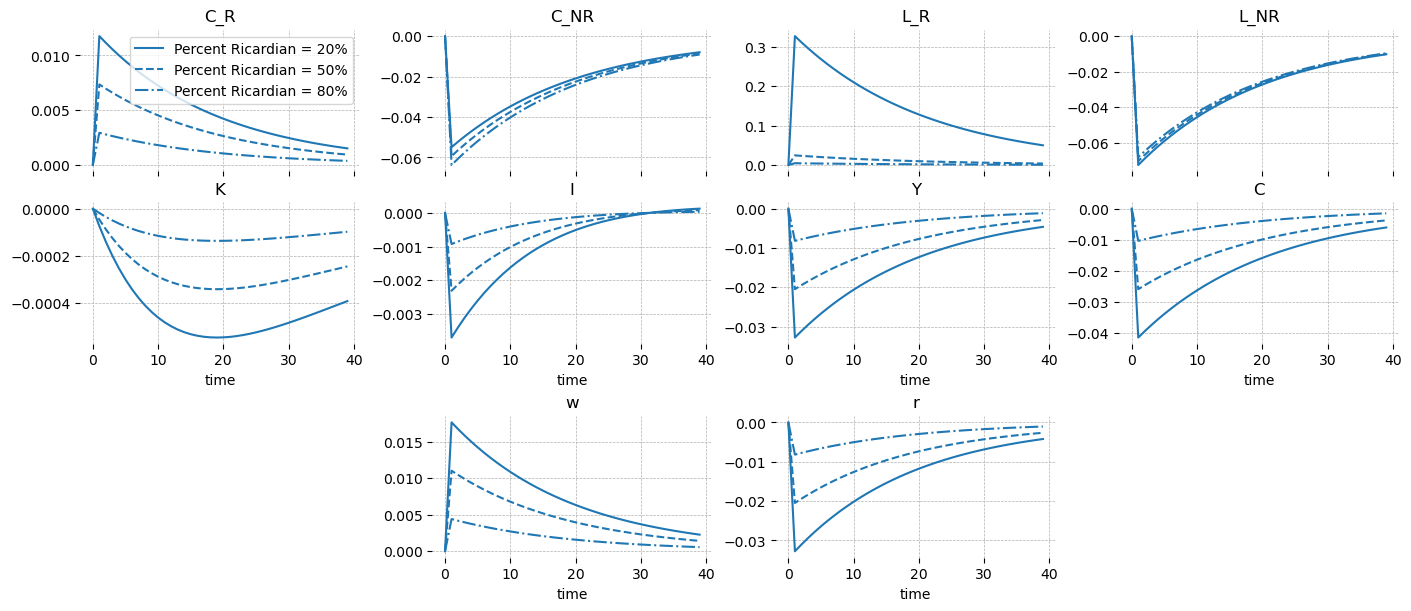

In [36]:
gp.plot_irf(
    {
        f"Percent Ricardian = {omega:0.0%}": ge.impulse_response_function(
            mod,
            shock_size={"epsilon_Theta_N": 0.1},
            verbose=False,
            omega=omega,
            #             steady_state_kwargs={"how": "root", "verbose": False, "progressbar": False},
        )
        for omega in [0.2, 0.5, 0.8]
    },
    ["C_R", "C_NR", "L_R", "L_NR", "K", "I", "Y", "C", "w", "r"],
    figsize=(14, 6),
);

When Ricardian households are the ones who don't want to work ($\Theta_R$ increases), the story is largely the same, but the dynamics are simplier. The non-Ricardian households respond to higher wages by consuming more and working less, increasing their utility. The result is less labor in the econonmy overall, which drives down output. 

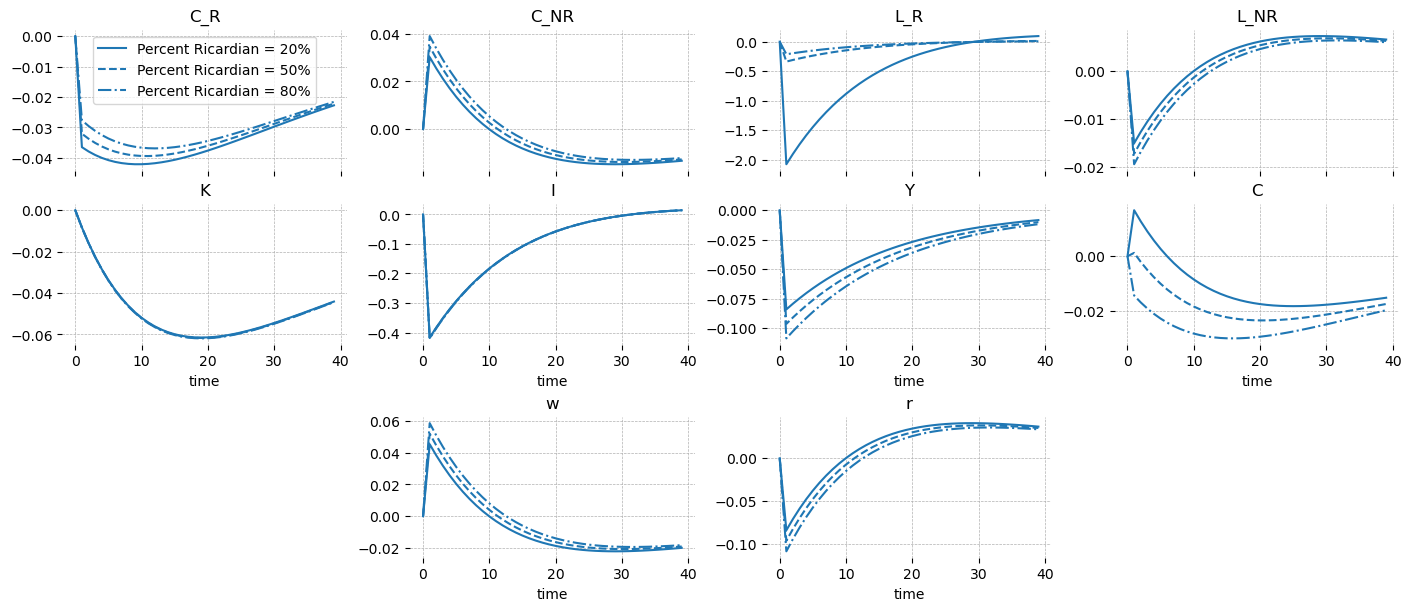

In [37]:
gp.plot_irf(
    {
        f"Percent Ricardian = {omega:0.0%}": ge.impulse_response_function(
            mod,
            shock_size={"epsilon_Theta_R": 0.1},
            verbose=False,
            omega=omega,
            #             steady_state_kwargs={"how": "root", "verbose": False, "progressbar": False},
        )
        for omega in [0.2, 0.5, 0.8]
    },
    ["C_R", "C_NR", "L_R", "L_NR", "K", "I", "Y", "C", "w", "r"],
    figsize=(14, 6),
);

# A Parameter Recovery Exercise

Since the analytical model is, well, analytical, we can fit a Bayesian model to it.

In [38]:
ss_mod = ge.statespace_from_gcn(gcn_file)
deep_params = list(ss_mod.param_dict.keys())

Model Building Complete.
Found:
	18 equations
	18 variables
		The following variables were eliminated at user request:
			TC_t, U_NR_t, U_R_t
		The following "variables" were defined as constants and have been substituted away:
			mc_t
	4 stochastic shocks
		 0 / 4 has a defined prior. 
	12 parameters
		 12 / 12 parameters has a defined prior. 
	0 parameters to calibrate.
Model appears well defined and ready to proceed to solving.



Statespace model construction complete, but call the .configure method to finalize.


In [39]:
ss_mod.configure(
    observed_states=["Y", "C", "C_R", "L", "L_R", "w"],
    measurement_error=["Y", "C", "C_R", "L", "L_R", "w"],
    full_shock_covaraince=True,
    solver="scan_cycle_reduction",
    mode="JAX",
    max_iter=20,
    use_adjoint_gradients=True,
)

                              Model Requirements                              
                                                                              
  Variable          Shape    Constraints                          Dimensions  
 ──────────────────────────────────────────────────────────────────────────── 
  Theta_N           ()                                                  None  
  Theta_R           ()                                                  None  
  alpha             ()                                                  None  
  beta              ()                                                  None  
  delta             ()                                                  None  
  omega             ()                                                  None  
  rho_TFP           ()                                                  None  
  rho_Theta_N       ()                                                  None  
  rho_Theta_R       ()                                                  None  
  rho_beta_R        ()                                                  None  
  sigma_N           ()       Positive                                   None  
  sigma_R           ()       Positive                                   None  
  state_cov         (4, 4)   Positive Semi-Definite   ('shock', 'shock_aux')  
  error_sigma_Y     ()                                                  None  
  error_sigma_C     ()                                                  None  
  error_sigma_C_R   ()                                                  None  
  error_sigma_L     ()                                                  None  
  error_sigma_L_R   ()                                                  None  
  error_sigma_w     ()                                                  None  
                                                                              
 These parameters should be assigned priors inside a PyMC model block before  
                  calling the build_statespace_graph method.                  

## Model definition

This model has 4 shocks. It can be interesting, but difficult, to learn about covariances between shocks. One way to learn these covariances is to define a prior over *covariance matrices*. This can be done in PyMC using an `LKJCholeskyCov` prior. This prior has a parameter $\eta$ that controls shrinkage towards diagonal matrices by making the correlation parmeters more and more concentrated arond zero. So, the higher is $\eta$, the more diagonal your matrices will be. When $\eta = 1$, the correlations are uniform between -1 and 1.

In [40]:
all_priors = ss_mod.param_priors | ss_mod.shock_priors

with pm.Model(coords=ss_mod.coords) as pm_mod:
    ss_mod.to_pymc()
    for var_name in ss_mod.error_states:
        x = pz.maxent(pz.Gamma(), lower=0.01, upper=0.05, plot=False)
        all_priors[f"error_sigma_{var_name}"] = x
        x.to_pymc(name=f"error_sigma_{var_name}")

    chol, *_ = pm.LKJCholeskyCov(
        "state_chol", n=4, eta=6, sd_dist=pm.HalfNormal.dist(sigma=0.05)
    )
    cov = pm.Deterministic("state_cov", chol @ chol.T, dims=["shock", "shock_aux"])

## Generate data using draws from the prior

In [41]:
true_params, data, prior = ge.data_from_prior(ss_mod, pm_mod, random_seed=rng)

/Users/jessegrabowski/mambaforge/envs/geconpy-dev/lib/python3.12/site-packages/pymc_extras/statespace/utils/data_tools.py:159: ImputationWarning: Provided data contains missing values and will be automatically imputed as hidden states during Kalman filtering.
  warnings.warn(impute_message, ImputationWarning)


Sampling: [Theta_N, Theta_R, alpha, beta, delta, error_sigma_C, error_sigma_C_R, error_sigma_L, error_sigma_L_R, error_sigma_Y, error_sigma_w, obs, omega, rho_TFP, rho_Theta_N, rho_Theta_R, rho_beta_R, sigma_N, sigma_R, state_chol]


Sampling: [prior_combined]


Output()

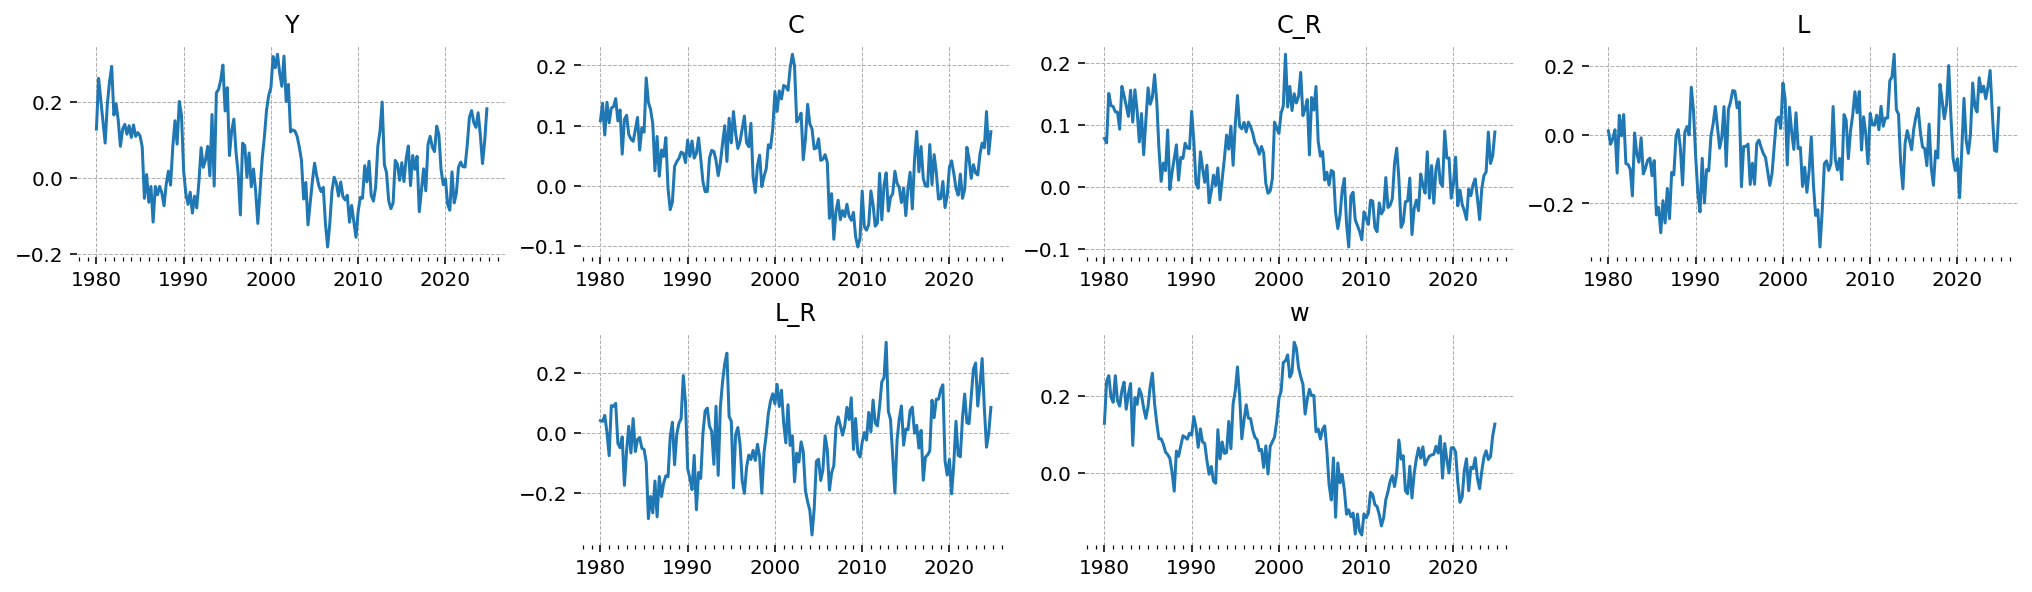

In [42]:
gp.plot_timeseries(data, ss_mod.observed_states);

## Sampling

For MCMC, we use Normalizing Flow (Fisher-Adaptive) NUTS, implemented in Nutpie.

In [43]:
with pm_mod:
    ss_mod.build_statespace_graph(
        data,
        add_norm_check=True,
        add_solver_success_check=True,
        add_steady_state_penalty=True,
    )

In [44]:
import nutpie as ntp

ntp_mod = ntp.compile_pymc_model(
    pm_mod,
    backend="jax",
    gradient_backend="jax",
    freeze_model=True,
    default_initialization_strategy="prior",
    jitter_rvs=set(),
    initial_points=mod.parameters(),
)

/Users/jessegrabowski/mambaforge/envs/geconpy-dev/lib/python3.12/site-packages/pymc/pytensorf.py:958: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(


/Users/jessegrabowski/mambaforge/envs/geconpy-dev/lib/python3.12/site-packages/pymc/pytensorf.py:958: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(


In [45]:
idata = ntp.sample(
    ntp_mod.with_transform_adapt(verbose=False),
    tune=1000,
    draws=500,
    chains=6,
    transform_adapt=True,
)

## Sampling Diagnostics

Sampling proceeds well. There are few divergences, good energy, and high effective samples.

<Axes: >

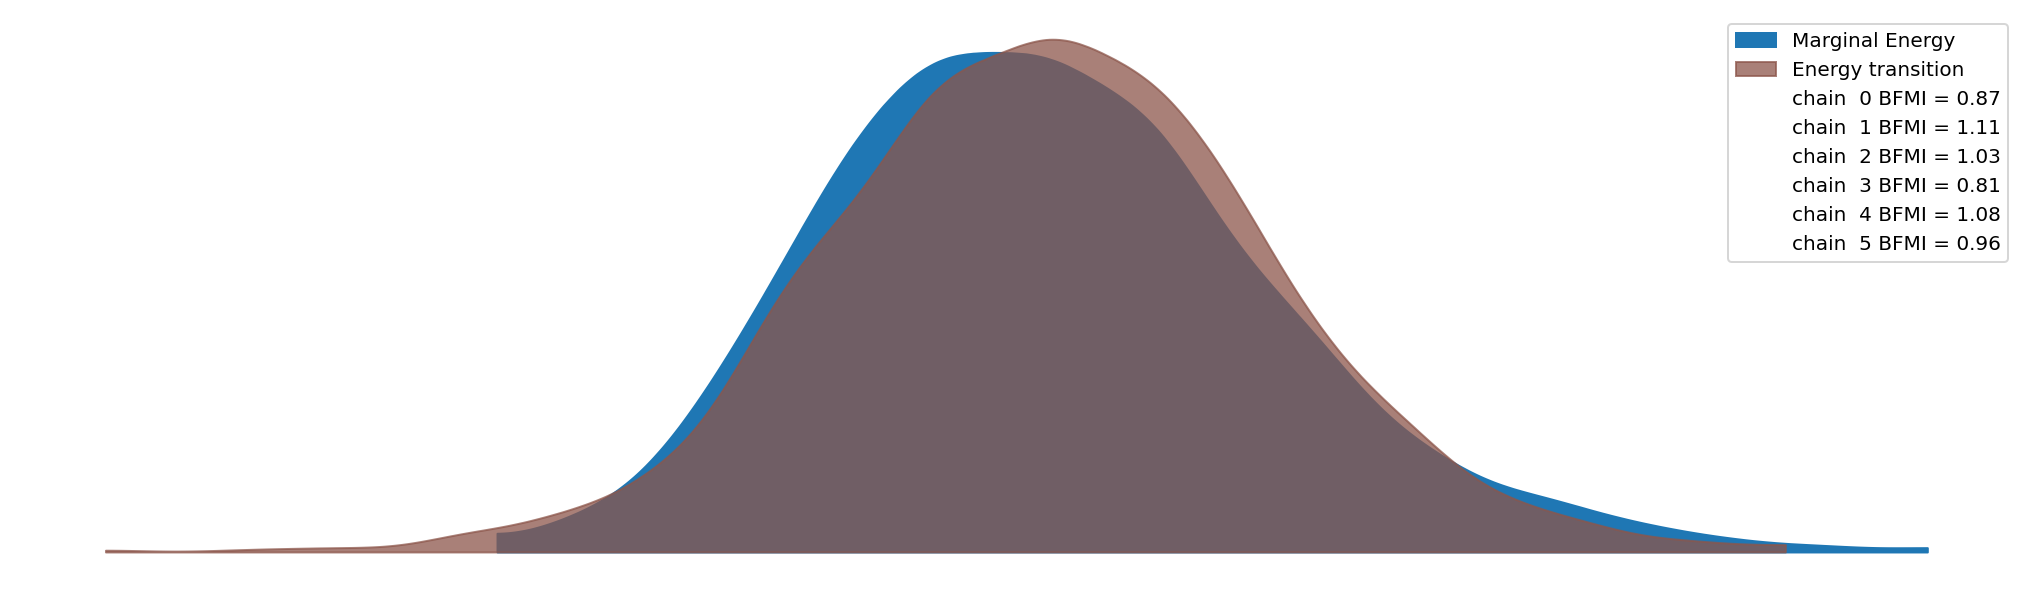

In [46]:
az.plot_energy(idata)

In [47]:
az.summary(idata, var_names=deep_params)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Theta_N      2.283  1.434   0.214    4.931      0.022    0.018    4855.0   
Theta_R      2.326  1.402   0.371    4.902      0.021    0.019    5753.0   
alpha        0.369  0.057   0.267    0.481      0.001    0.001    4408.0   
beta         0.962  0.011   0.941    0.981      0.000    0.000    4006.0   
delta        0.030  0.008   0.016    0.045      0.000    0.000    4408.0   
omega        0.806  0.069   0.679    0.928      0.001    0.001    5009.0   
rho_TFP      0.919  0.028   0.865    0.966      0.000    0.000    4890.0   
rho_Theta_N  0.788  0.122   0.575    0.987      0.002    0.001    4184.0   
rho_Theta_R  0.523  0.141   0.261    0.787      0.002    0.002    4002.0   
rho_beta_R   0.785  0.079   0.641    0.929      0.001    0.001    3928.0   
sigma_N      2.330  0.336   1.766    2.987      0.005    0.004    4525.0   
sigma_R      1.671  0.055   1.561    1.770      0.001    0.001    4940.0   

             ess_tail  r_hat  
Theta_N        2272.0   1.00  
Theta_R        2043.0   1.00  
alpha          2276.0   1.00  
beta           1789.0   1.00  
delta          2368.0   1.00  
omega          2223.0   1.01  
rho_TFP        2313.0   1.00  
rho_Theta_N    2220.0   1.00  
rho_Theta_R    2234.0   1.00  
rho_beta_R     1899.0   1.00  
sigma_N        2364.0   1.00  
sigma_R        2301.0   1.00

## Posteriors

We can see that we recover most of the true parameter values. $\Theta_N$, $\Theta_R$, and $\rho_{\Theta_N}$ are not identified. This might be a function of the time series we chose to show to the model, as we omitted $L_{NR}$.

This isn't actually a problem perse, but it does put more pressure on us to choose priors that make sense. We should always still like to incorporate uncertainty about the value of these parameters. This is _especially_ true when the data isn't informative! We certainly don't believe that these parameters have fixed values at 1.0, so it's better that our outputs take into account what values they *could* take on.

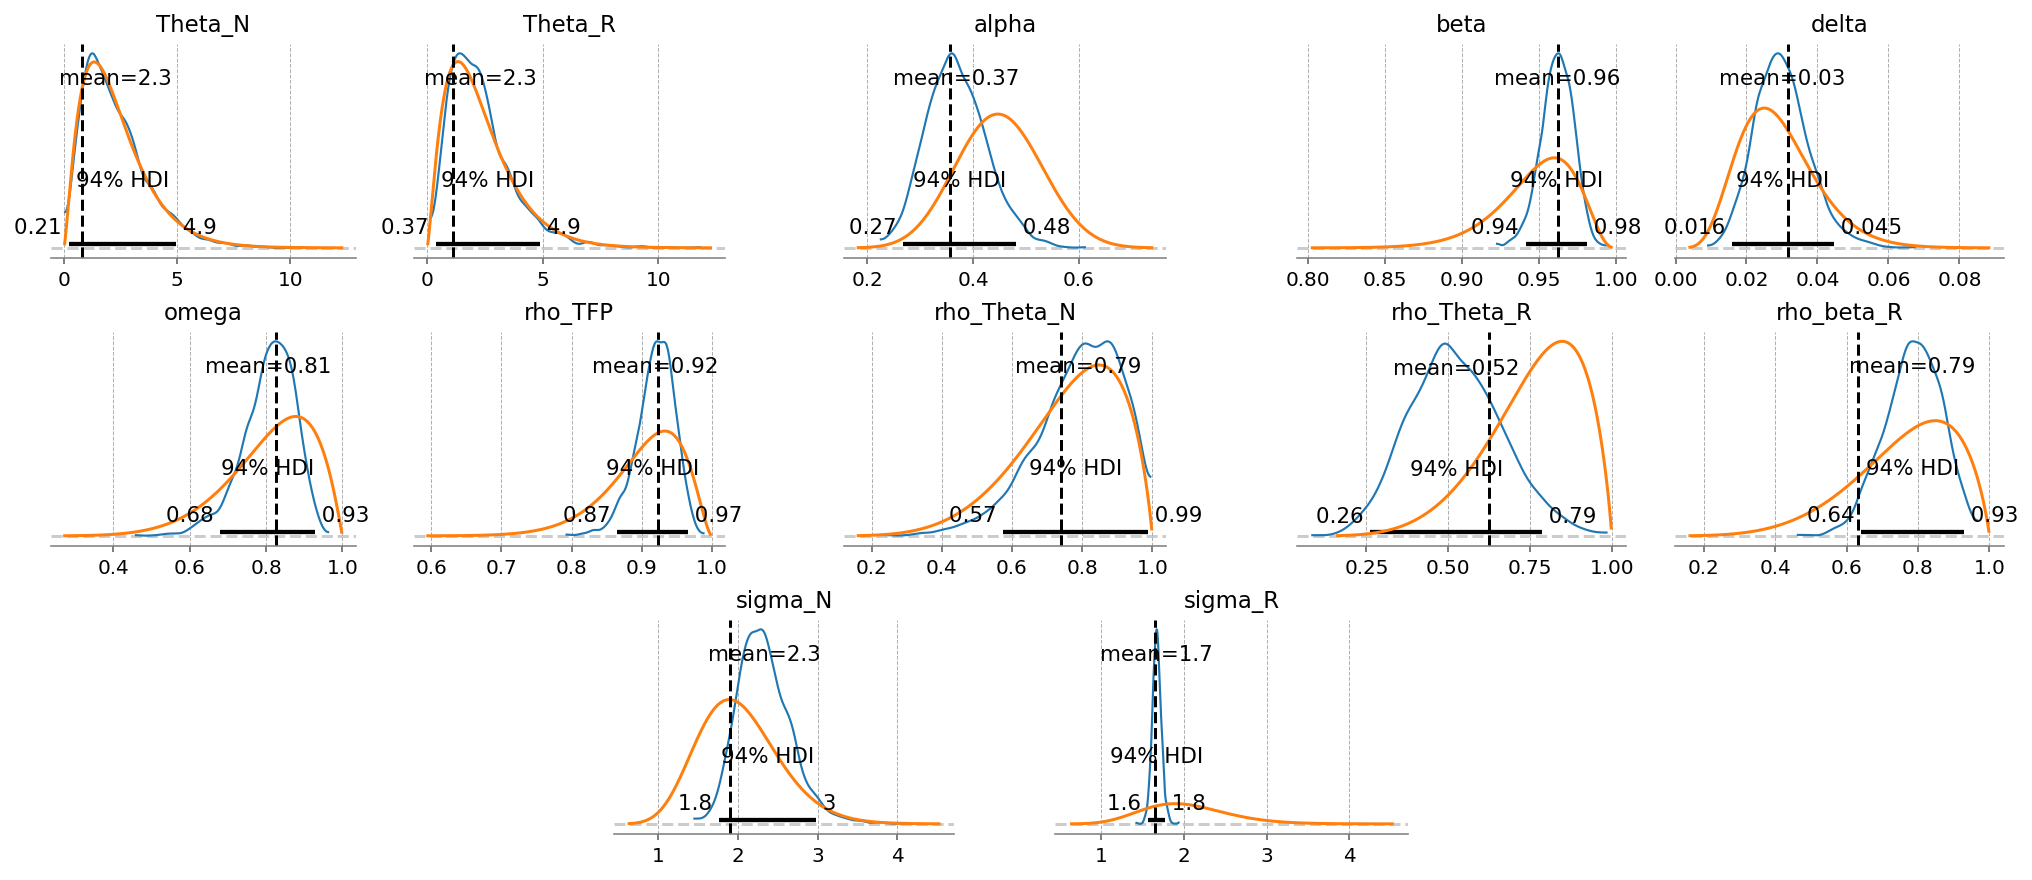

In [48]:
fig = gp.plot_posterior_with_prior(idata, var_names=deep_params, prior_dict=all_priors)
for axis in fig.axes:
    axis.axvline(true_params[axis.get_title()].item(), color="k", ls="--")

It's also important remember that the posterior is a high dimensional object. When we look at the plots like those above, we're looking at *marginal distributions*. These don't tell the entire story, because there could be complex correlation structure between the individual parameter dimensions in the posterior. 

Looking at a **corner plot** can reveal some of that structure, by plotting each pair of parameteters. We see for example a banana-shaped relationship between $\omega$ and $\Theta_R$, which suggets that these parameters are highly coupled. There is also a strong positive correlation between $\delta$ and $\beta$

/Users/jessegrabowski/mambaforge/envs/geconpy-dev/lib/python3.12/site-packages/corner/core.py:133: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(


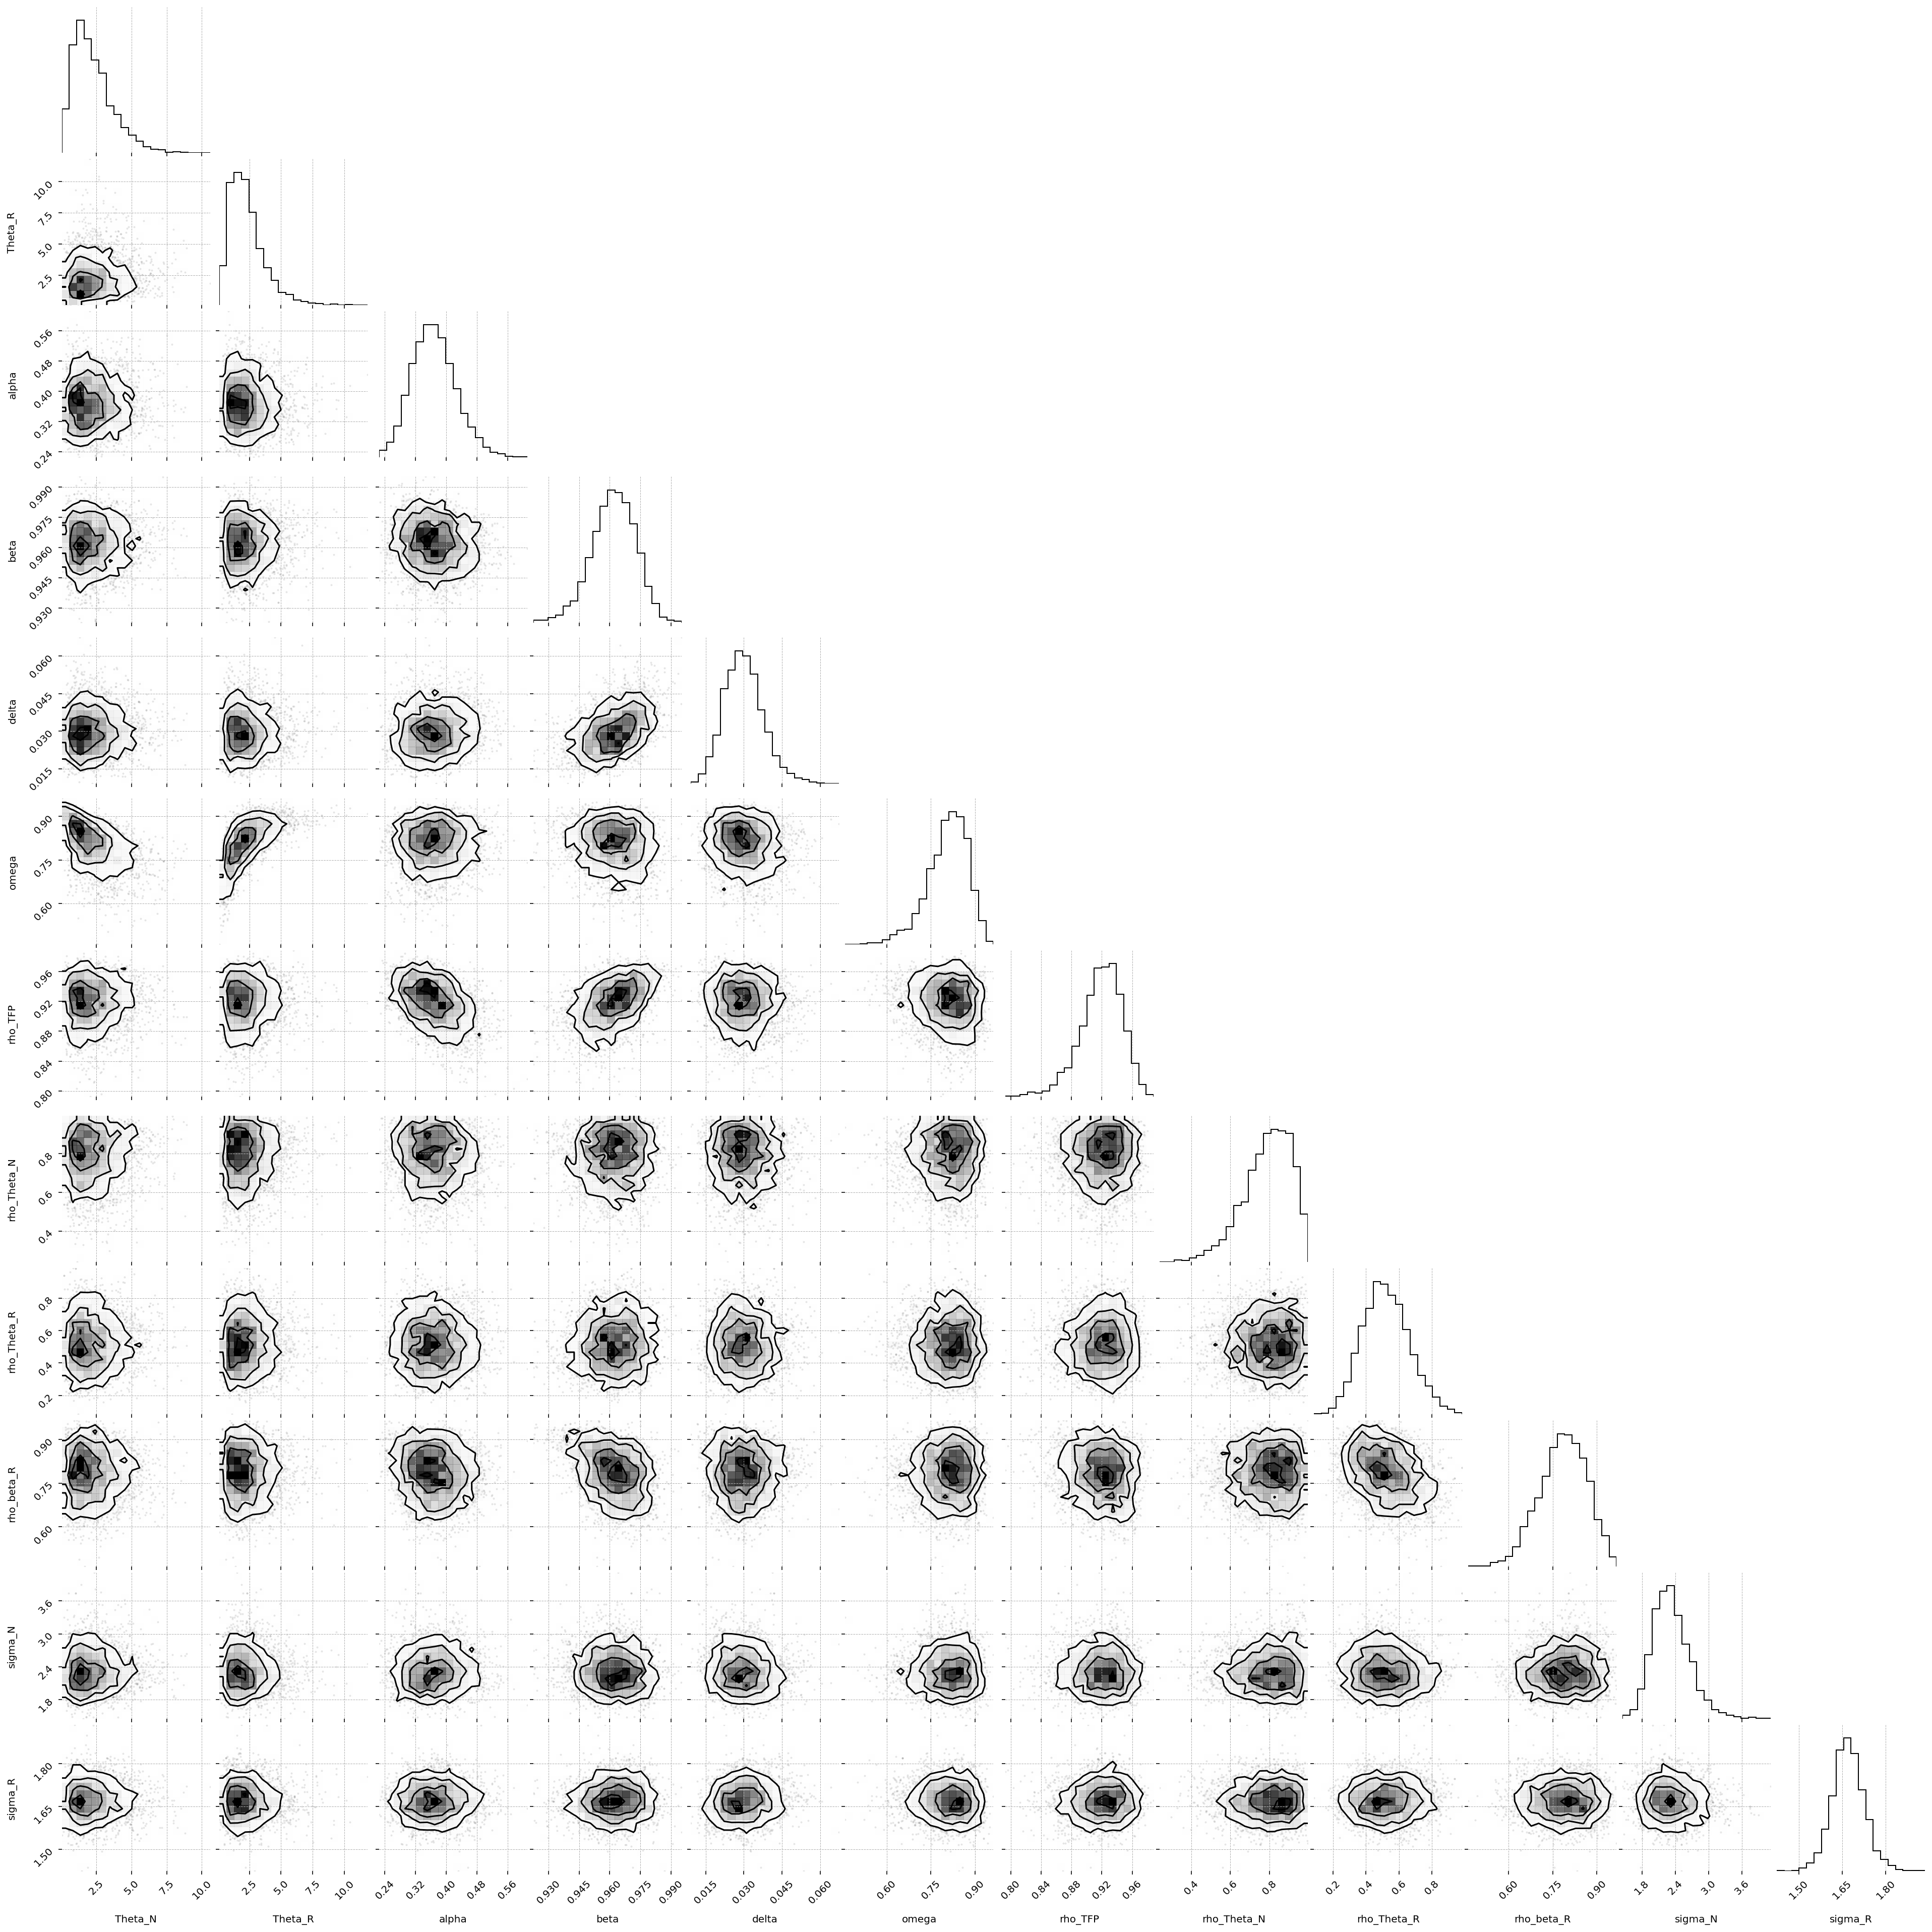

In [49]:
from corner import corner

fig = corner(
    idata,
    var_names=deep_params,
    divergences=False,
    divergences_kwargs={"markersize": 4, "color": "tab:red"},
)

We can also look at the learned correlatons between the shocks. We see that in the sampled data, there was a positive correlation between TFP and $\Theta_R$ shocks, which was recovered in the posterior. The negative correlation between $\Theta_R$ and $\Theta_N$ was not found, though. This is consistent with $\Theta_N$ itself being unidentified.

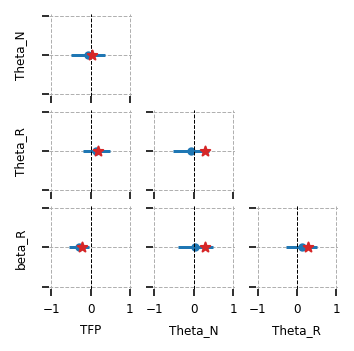

In [50]:
from itertools import product

fig = gp.plot_estimated_matrix(
    idata,
    ss_mod,
    matrix_name="state_chol_corr",
    subplot_kwargs=dict(
        figsize=(3, 3),
        dpi=144,
        sharex=True,
        sharey=True,
        subplot_kw={"aspect": "equal"},
    ),
)
true_corr = true_params["state_chol_corr"].values
for (i, j), axis in zip(product([0, 1, 2, 3], [0, 1, 2, 3]), fig.axes):
    if axis.get_visible():
        axis.scatter(true_corr[i, j], 0, c="tab:red", marker="*", s=25, zorder=100)
plt.show()

# Post-Estimation

In [51]:
cond_post = ss_mod.sample_conditional_posterior(idata, random_seed=rng)

/Users/jessegrabowski/mambaforge/envs/geconpy-dev/lib/python3.12/site-packages/pytensor/link/jax/linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x99420AB20>), RNG(<Generator(PCG64) at 0x99420AA40>), RNG(<Generator(PCG64) at 0x99420A960>), RNG(<Generator(PCG64) at 0x99420A880>), RNG(<Generator(PCG64) at 0x99420A7A0>), RNG(<Generator(PCG64) at 0x99D7A8BA0>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(


Sampling: [filtered_posterior, filtered_posterior_observed, predicted_posterior, predicted_posterior_observed, smoothed_posterior, smoothed_posterior_observed]


Output()

## Filtered Observed States

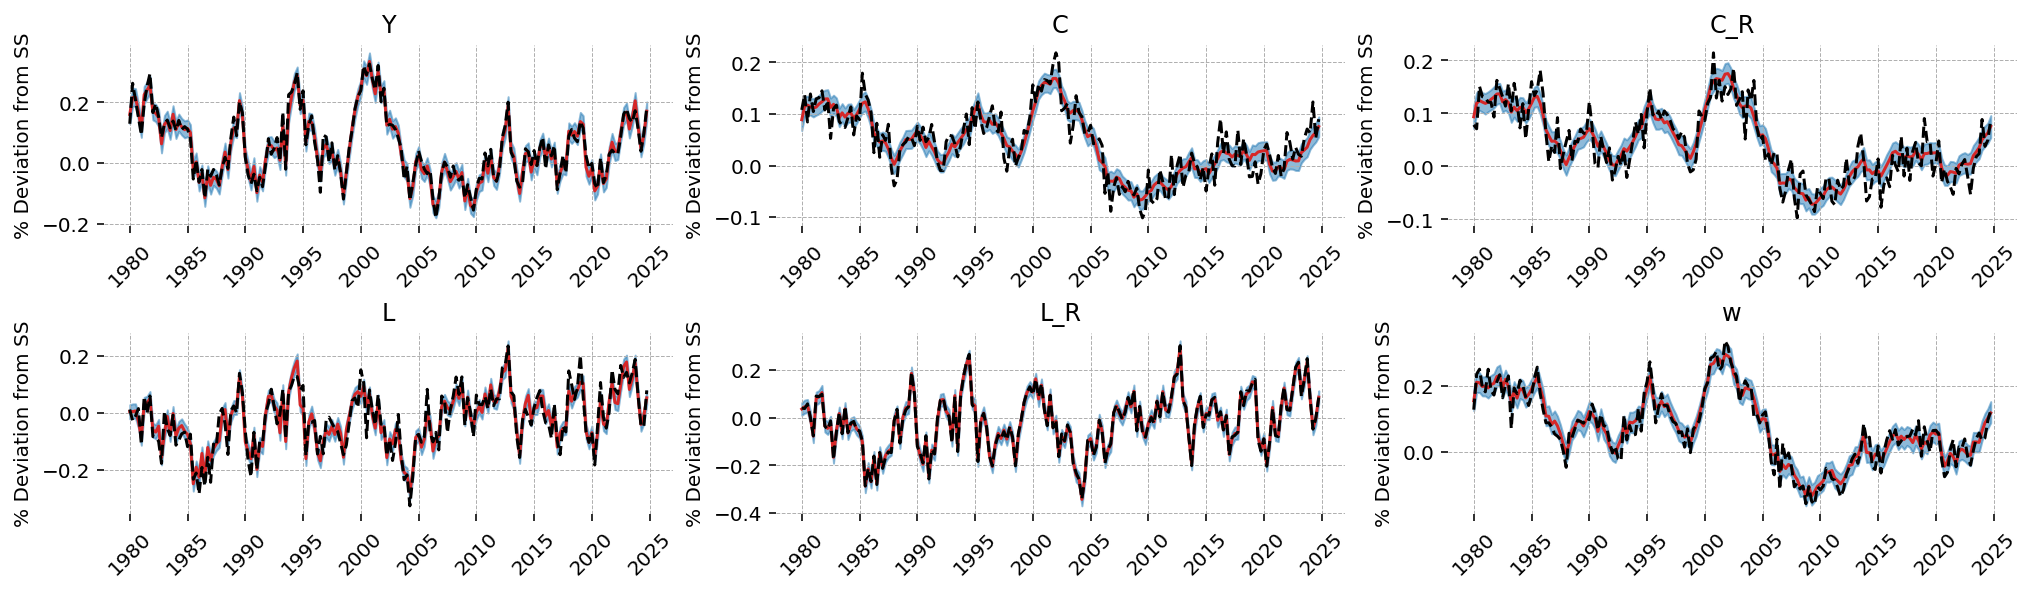

In [52]:
fig = gp.plot_kalman_filter(
    cond_post,
    data,
    kalman_output="smoothed",
    vars_to_plot=data.columns,
    n_cols=3,
    figsize=(14, 4),
);

## Filtered Unobserved States

In [53]:
idx = true_params["param_idx"].item()
unobserved_data = (
    prior.unconditional_prior.sel(chain=0, draw=idx)
    .to_dataframe()["prior_latent"]
    .unstack("state")
    .droplevel(axis=0, level=1)
    .drop_duplicates()
)

Although the model was not shown data for a non-ricardian households, it is able to faithfully recover these time series.

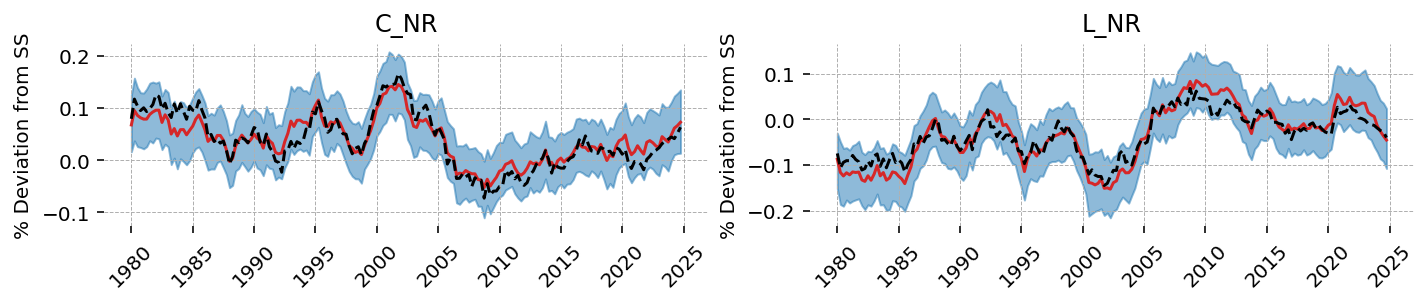

In [54]:
fig = gp.plot_kalman_filter(
    cond_post,
    unobserved_data,
    kalman_output="smoothed",
    vars_to_plot=["C_NR", "L_NR"],
    n_cols=3,
    figsize=(14, 2),
);

We can see that the Kalman Filter also recovers the unobserved shock series: TFP, $\Theta_R$ and $\beta_R$. As noted twice already, it fails to recover $\Theta_N$.

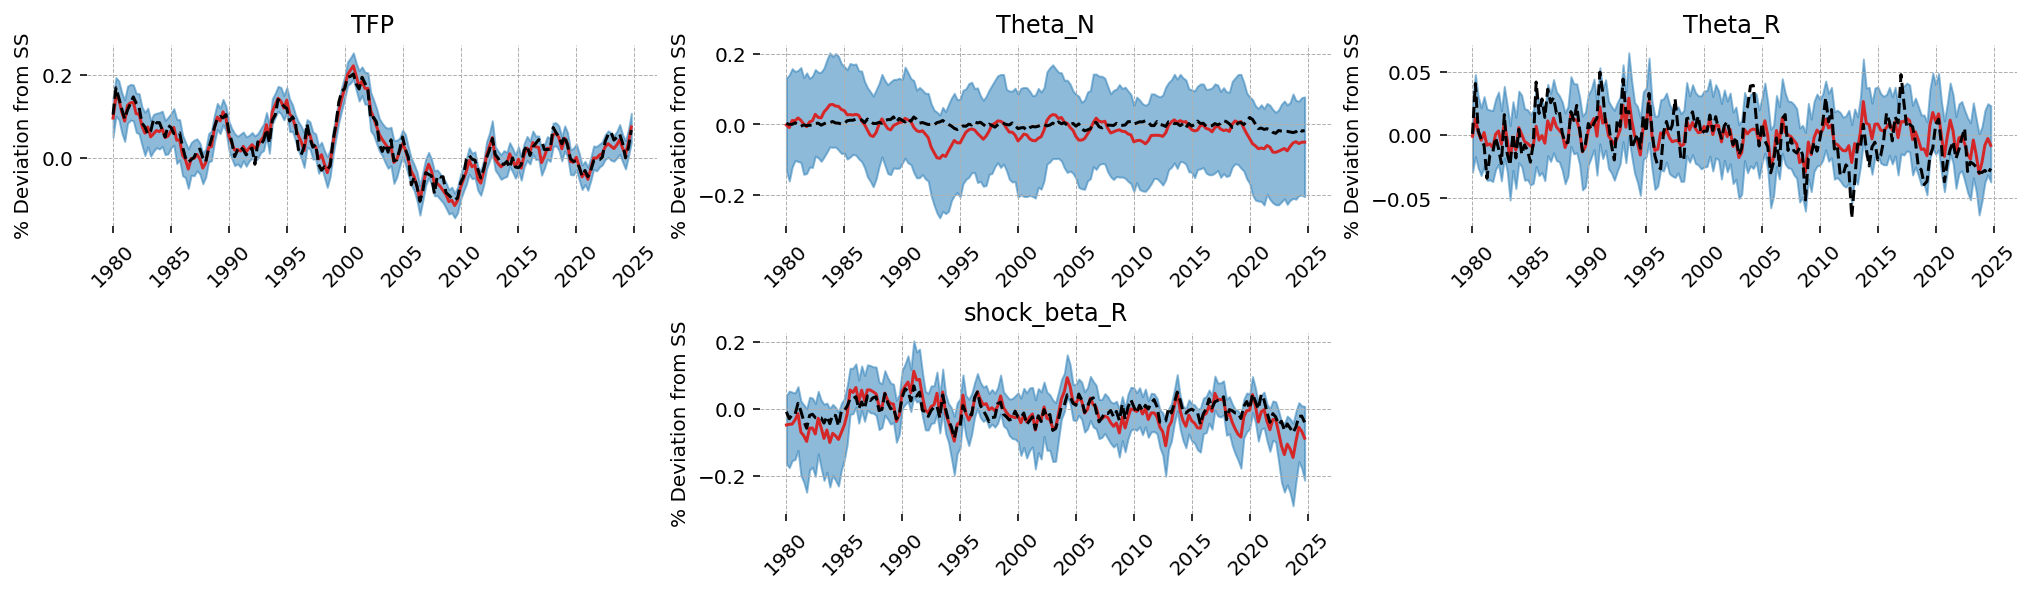

In [55]:
fig = gp.plot_kalman_filter(
    cond_post,
    unobserved_data,
    kalman_output="smoothed",
    vars_to_plot=["TFP", "Theta_N", "Theta_R", "shock_beta_R"],
    n_cols=3,
    figsize=(14, 4),
);

## Impulse Response Functions

We conclude by plotting impulse response functions over selected states. Unlike the IRFs we looked at at the beginning of this notebook, these incorporate uncertainty about the true parameter values.

In [56]:
shock_size = np.zeros(ss_mod.k_posdef)

idx = ss_mod.shock_names.index("epsilon_TFP")
shock_size[idx] = 0.1

irf = ss_mod.impulse_response_function(
    idata, n_steps=40, shock_size=shock_size, random_seed=rng
)

Sampling: []


Output()

In [57]:
def plot_irf(irf, vars_to_plot, n_cols=2, figsize=(14, 8), dpi=144, title=None):
    n_plots = len(vars_to_plot)
    n_cols = min(n_plots, n_cols)
    fig = plt.figure(figsize=figsize, dpi=dpi, layout="constrained")
    gs, locs = gp.prepare_gridspec_figure(n_cols=n_cols, n_plots=n_plots, figure=fig)

    data = irf.irf.sel(state=vars_to_plot)

    mu = data.mean(dim=["chain", "draw"])
    hdi = az.hdi(data).irf
    time = mu.time

    for variable, loc in zip(vars_to_plot, locs):
        axis = fig.add_subplot(gs[loc])
        axis.plot(time, mu.sel(state=variable))
        axis.fill_between(time, *hdi.sel(state=variable).values.T, alpha=0.2)
        axis.set_title(variable)
    if title:
        fig.suptitle(title)

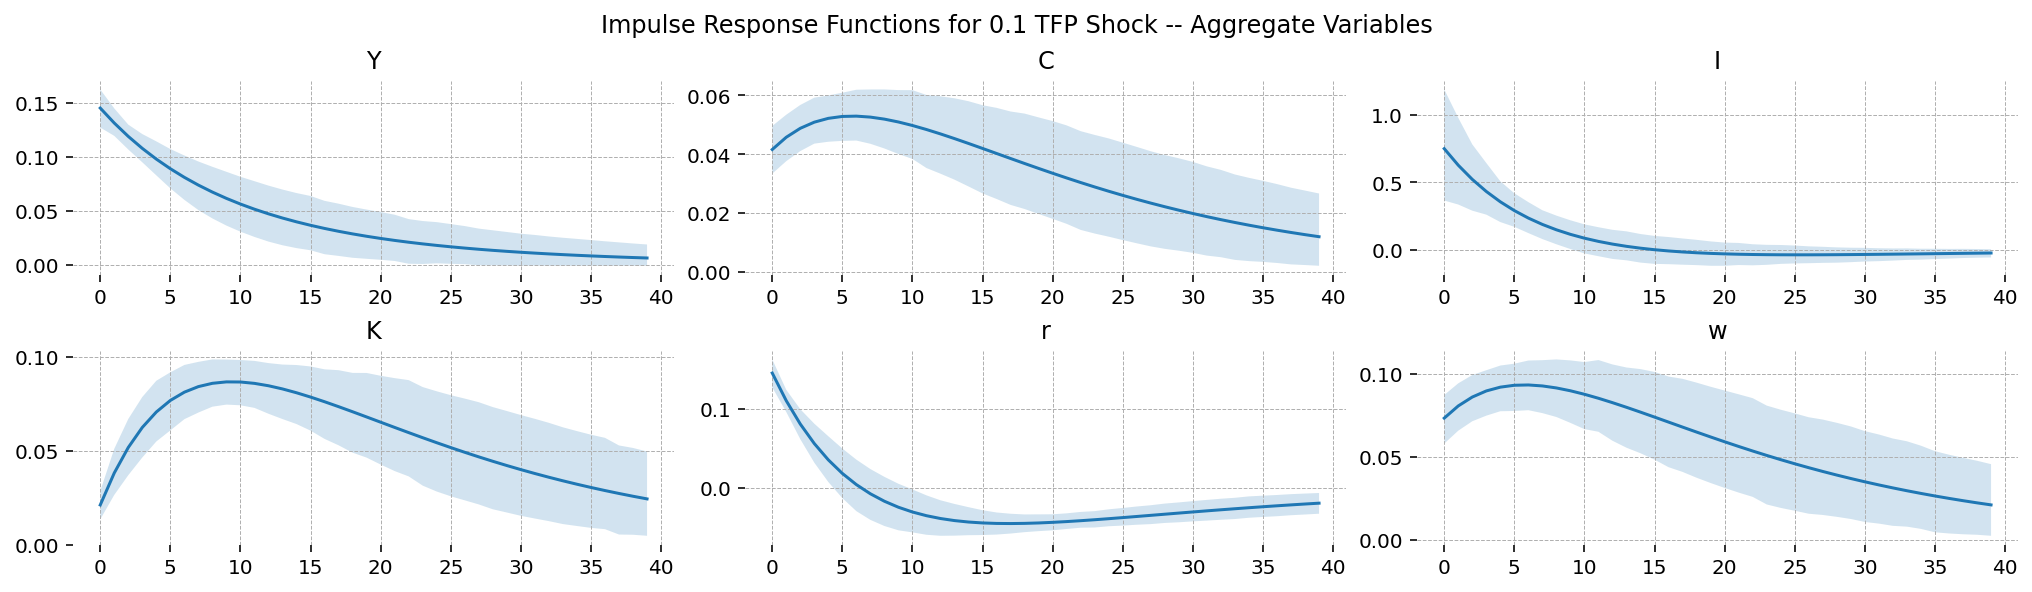

In [58]:
plot_irf(
    irf,
    ["Y", "C", "I", "K", "r", "w"],
    n_cols=3,
    figsize=(14, 4),
    title="Impulse Response Functions for 0.1 TFP Shock -- Aggregate Variables",
)

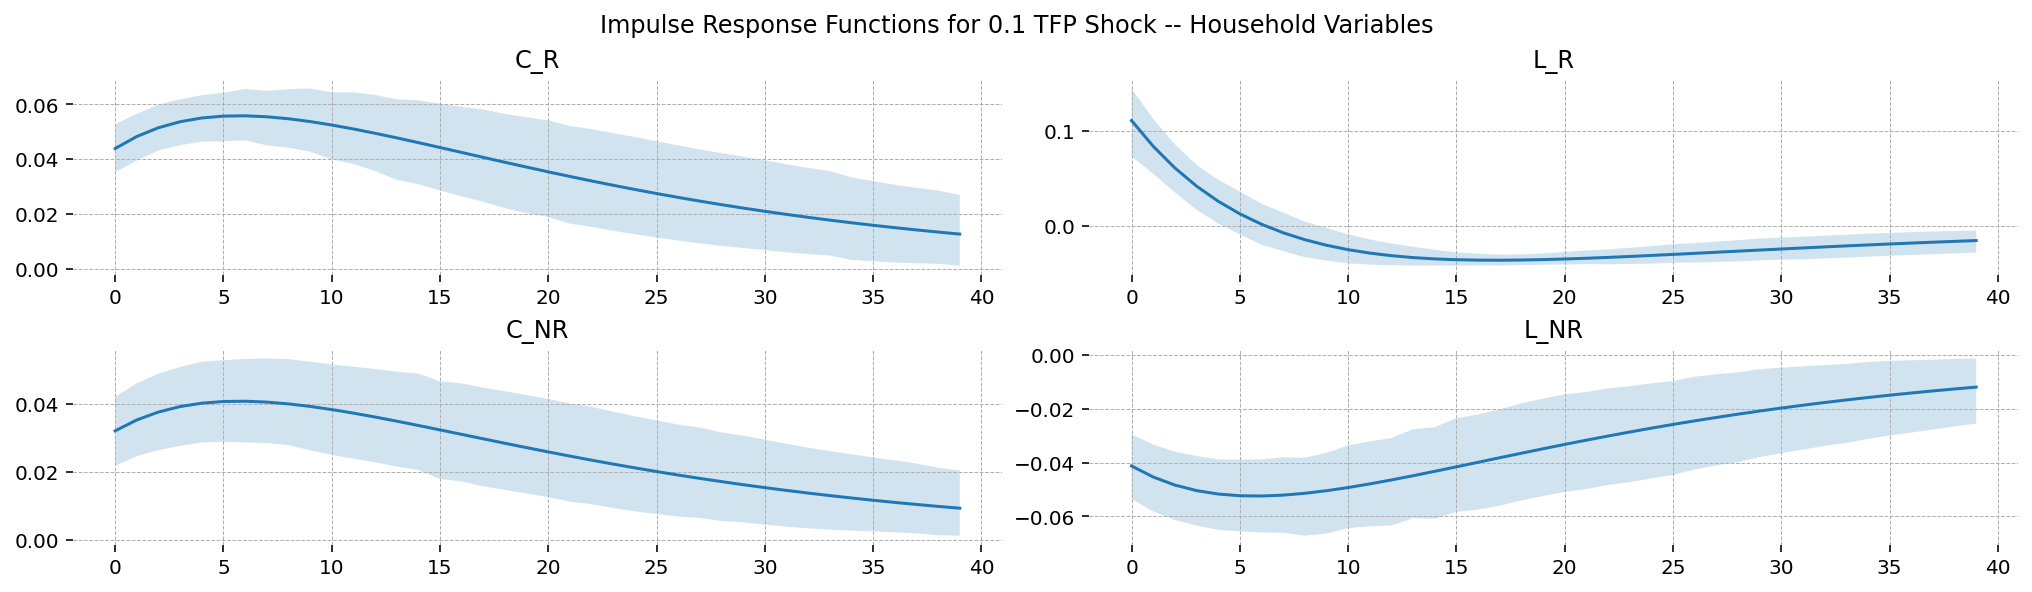

In [59]:
plot_irf(
    irf,
    ["C_R", "L_R", "C_NR", "L_NR"],
    n_cols=2,
    figsize=(14, 4),
    title="Impulse Response Functions for 0.1 TFP Shock -- Household Variables",
)

# Authors

- Authored by Jesse Grabowski in March 2025 

# Watermark

In [60]:
%load_ext watermark
%watermark -n -u -v -iv -w -p gEconpy

Last updated: Sat Mar 15 2025

Python implementation: CPython
Python version       : 3.12.9
IPython version      : 9.0.1

gEconpy: 0+untagged.305.gd931e48.dirty

preliz    : 0.15.0
arviz     : 0.20.0
gEconpy   : 0+untagged.305.gd931e48.dirty
corner    : 2.2.3
numpy     : 1.26.4
matplotlib: 3.10.1
pandas    : 2.2.3
pymc      : 5.21.1
nutpie    : 0.14.0

Watermark: 2.5.0

